## News Analysys 

Dataset : https://www.kaggle.com/rmisra/news-category-dataset/version/2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('popular', quiet=True)

True

In [4]:
# Loading the dataset
df = pd.read_json('News_Category_Dataset_v2.json.zip', lines=True, compression='zip')
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


### Exploring the dataset

In [14]:
df.describe()

,authors,category,date,headline,link,short_description
count,200853,200853,200853,200853,200853,200853
unique,27993,41,2309,199344,200812,178353
top,,POLITICS,2013-01-17 00:00:00,Sunday Roundup,https://www.huffingtonpost.comhttps://www.publ...,
freq,36620,32739,100,90,2,19712
first,NaN,NaN,2012-01-28 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-05-26 00:00:00,NaN,NaN,NaN


In [8]:
categories = df.category.unique()
categories

array([u'CRIME', u'ENTERTAINMENT', u'WORLD NEWS', u'IMPACT', u'POLITICS',
       u'WEIRD NEWS', u'BLACK VOICES', u'WOMEN', u'COMEDY',
       u'QUEER VOICES', u'SPORTS', u'BUSINESS', u'TRAVEL', u'MEDIA',
       u'TECH', u'RELIGION', u'SCIENCE', u'LATINO VOICES', u'EDUCATION',
       u'COLLEGE', u'PARENTS', u'ARTS & CULTURE', u'STYLE', u'GREEN',
       u'TASTE', u'HEALTHY LIVING', u'THE WORLDPOST', u'GOOD NEWS',
       u'WORLDPOST', u'FIFTY', u'ARTS', u'WELLNESS', u'PARENTING',
       u'HOME & LIVING', u'STYLE & BEAUTY', u'DIVORCE', u'WEDDINGS',
       u'FOOD & DRINK', u'MONEY', u'ENVIRONMENT', u'CULTURE & ARTS'],
      dtype=object)

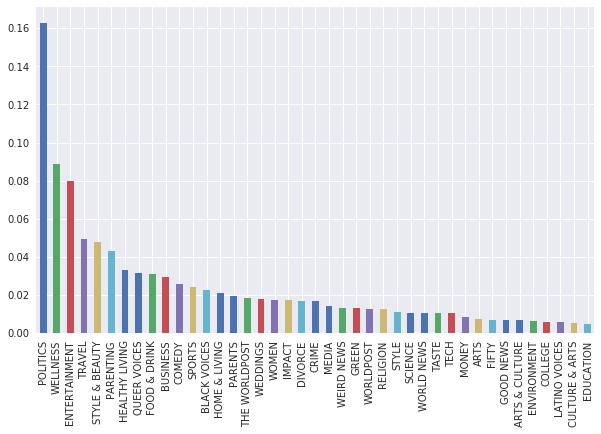

In [16]:
df.category.value_counts(normalize=True).plot(kind='bar', figsize=(10,6))

Note: The number of articles per category is not equally distributed.
This could be taken into account at model building time (artificially balance the dataset by applying under/over-sampling technics, penalize classification,...?).

In [17]:
df.authors.value_counts()

                                                                                                       36620
Lee Moran                                                                                               2423
Ron Dicker                                                                                              1913
Reuters, Reuters                                                                                        1562
Ed Mazza                                                                                                1322
Cole Delbyck                                                                                            1140
Andy McDonald                                                                                           1068
Julia Brucculieri                                                                                       1059
Carly Ledbetter                                                                                         1054
Curtis M. Wong     

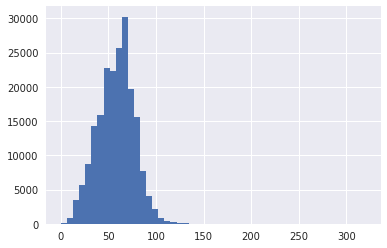

In [18]:
df.headline.map(len).hist(bins=50)

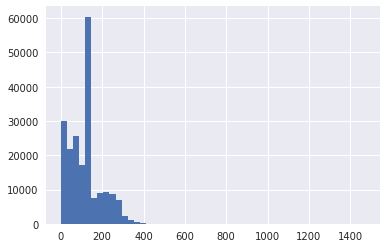

In [19]:
df.short_description.map(len).hist(bins=50)

In [20]:
df[df['authors'].str.contains('Sam Stein')]['authors'].unique()

array([u'Jason Cherkis and Sam Stein', u'Sam Stein and Jason Cherkis',
       u'Sam Stein', u'Sam Levine and Sam Stein',
       u'Sam Stein, Jason Cherkis, and Zach Young',
       u'Sam Stein and Matt Fuller', u'Matt Fuller and Sam Stein',
       u'Sam Stein and Jessica Schulberg',
       u'Michael McAuliff and Sam Stein', u'Marina Fang and Sam Stein',
       u'S.V. Date and Sam Stein', u'Sam Stein and Paul Blumenthal',
       u'Jessica Schulberg and Sam Stein', u'Zach Carter and Sam Stein',
       u'Sam Stein and Laura Barr\xf3n-L\xf3pez',
       u'Michael Calderone and Sam Stein', u'Igor Bobic and Sam Stein',
       u'Sam Stein and Ryan Grim', u'Sam Stein and Igor Bobic',
       u'Sam Stein and Amanda Terkel', u'Ryan Grim and Sam Stein',
       u'Amanda Terkel and Sam Stein',
       u'Sam Stein, Michael McAuliff, and Matt Fuller',
       u'Jennifer Bendery and Sam Stein', u'Jeffrey Young and Sam Stein',
       u'Ryan Grim, Sam Stein, and Matt Fuller',
       u'Eline Gordts and Sam St

Note: The authors columns can contain multiple authors and need some prepreocessing if used.

### Features Engineering

#### Utilitites to perform text preprocessing:

* Tokenization
* Stop Words Removal
* Stemmatization

In [5]:
import json
from nltk.corpus import stopwords
from string import punctuation

stops = set(stopwords.words('english')).union(set(punctuation))

# Union nltk stopwords with https://github.com/6/stopwords-json/blob/master/stopwords-all.json
with open('stopwords-json/stopwords-all.json') as json_data:
    stops2 = json.load(json_data)['en']
    stops = set(stops.union(set(stops2)))

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize
import itertools
import re

from nltk.stem import PorterStemmer
porter = PorterStemmer()

import spacy
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def custom_tokenizer(text, stemming=True):
    text = clean_text(text)
    tokens = list(itertools.chain(*[word_tokenize(x) for x in sent_tokenize(text)]))
    tokens = list(filter(lambda token: token not in stops, tokens))
    if stemming:
        tokens = [porter.stem(x) for x in tokens]
    return tokens
  
def lemma_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

#### Exploring text encodings

#### Bag of words

We'll compute the bag-of-words from text (headline + short_description) by applying the following three steps:

* Tokenization. Split each text into the words (called tokens)
* Vocabulary Collection.
* Encoding. For each text, count how often each of the words in the vocabulary appear in this document.

We'll use the custom_tokenizer from utilities above, to extract token, remove stop words (uninformative words) since the corpus is composed of short text and stemming and/or lemmatization (that will reduced the number of features as well).

In [17]:
# Word Category Content
from collections import Counter

df['tokens'] = (df['headline'] + df['short_description']).map(lambda d: custom_tokenizer(d, False))
for category in categories:
    tokens = df[df['category']==category]['tokens']
    cat_tokens = []
    for token_list in tokens:
        cat_tokens += token_list
    counter = Counter(cat_tokens)
    print(category, counter.most_common(20))

(u'CRIME', [(u'police', 688), (u'man', 553), (u'year', 383), (u'shooting', 322), (u'allegedly', 265), (u'suspect', 262), (u'killed', 252), (u'found', 247), (u'woman', 237), (u'shot', 230), (u'accused', 204), (u'death', 201), (u'officer', 200), (u'arrested', 196), (u'murder', 191), (u'people', 190), (u'dead', 189), (u'video', 177), (u'cops', 155), (u'charged', 153)])
(u'ENTERTAINMENT', [(u'trump', 839), (u'film', 820), (u'show', 797), (u'star', 759), (u'movie', 754), (u'year', 695), (u'time', 640), (u'music', 614), (u'love', 528), (u'back', 485), (u'season', 466), (u'people', 451), (u'actor', 450), (u'donald', 436), (u'day', 429), (u'watch', 427), (u'video', 423), (u'years', 418), (u'singer', 413), (u'make', 407)])
(u'WORLD NEWS', [(u'trump', 266), (u'north', 228), (u'korea', 211), (u'people', 172), (u'president', 158), (u'country', 137), (u'world', 133), (u'killed', 125), (u'attack', 110), (u'south', 106), (u'government', 101), (u'year', 96), (u'police', 94), (u'saudi', 94), (u'war', 8

(u'HEALTHY LIVING', [(u'life', 726), (u'health', 682), (u'people', 581), (u'time', 498), (u'make', 406), (u'ways', 351), (u'things', 350), (u'day', 338), (u'sleep', 328), (u'good', 307), (u'cancer', 277), (u'work', 267), (u'mental', 256), (u'year', 254), (u'care', 254), (u'love', 253), (u'change', 224), (u'healthy', 224), (u'feel', 212), (u'body', 203)])
(u'THE WORLDPOST', [(u'people', 350), (u'trump', 317), (u'president', 257), (u'killed', 243), (u'attack', 228), (u'world', 200), (u'state', 200), (u'syria', 198), (u'year', 193), (u'north', 180), (u'turkey', 180), (u'china', 179), (u'syrian', 179), (u'isis', 176), (u'country', 173), (u'government', 169), (u'korea', 163), (u'russia', 160), (u'minister', 146), (u'police', 143)])
(u'GOOD NEWS', [(u'dog', 140), (u'man', 113), (u'life', 89), (u'people', 84), (u'year', 81), (u'day', 79), (u'woman', 69), (u'boy', 67), (u'world', 66), (u'time', 65), (u'home', 62), (u'love', 61), (u'make', 61), (u'family', 60), (u'kids', 55), (u'homeless', 54),

In [18]:
# Text Encoding with CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2),
                     tokenizer=custom_tokenizer, min_df=5,
                     encoding='latin-1')
features = cv.fit_transform(df.headline + ' ' + df.short_description)
features.shape

(200853, 82544)

In [19]:
# Most frequent words
tmp = dict(zip(cv.get_feature_names(), np.asarray(features.sum(axis=0)).ravel()))
tmp = pd.DataFrame().from_dict(dict(tmp), orient='index')
tmp.columns = ['count']
tmp.sort_values(by=['count'], ascending=False).head(40)

,count
trump,18345
year,16623
time,14705
make,14352
photo,14308
day,14051
peopl,12327
life,9607
world,9075
love,8938


In [ ]:
words_freq = [(word, features.sum(axis=0)[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:30]

#### Rescaling the Data with tf–idf

An other approach of representing text is using the term frequency–inverse document frequency (tf–idf) method, which give high weight to any term that appears often in a particular document, but not in many documents in the corpus.

In [7]:
# Text Encoding with TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Params:
#sublinear_df is set to True to use a logarithmic form for frequency, to give diminishing returns as the frequency of a word increases.
#min_df is the minimum numbers of documents a word must be present in to be kept (remove rare words).
#norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
#encoding is set to latin-1
#ngram_range is set to (1, 2) to indicate that we want to consider both unigrams (single words) and bigrams (pair of words)
#tokenizer is set custom_tokenizer (from utilities above)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        norm='l2',encoding='latin-1', ngram_range=(1, 2),
                        tokenizer=custom_tokenizer)

text = df.headline + ' ' + df.short_description
features = tfidf.fit_transform(text).toarray()
features.shape

(200853, 82544)

In [8]:
tmp = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tmp = pd.DataFrame().from_dict(dict(tmp), orient='index')
tmp.columns = ['tfidf']
tmp.sort_values(['tfidf']).head(30)

,tfidf
trump,3.595395
year,3.616569
time,3.715792
make,3.720621
photo,3.727298
day,3.841111
peopl,3.889436
life,4.172681
world,4.214921
thing,4.234324


In [9]:
tmp.sort_values(by=['tfidf'], ascending=False).head(40)

,tfidf
local guid,11.418574
prevent ill,11.418574
idea busi,11.418574
peopl figur,11.418574
toni stark,11.418574
labor practic,11.418574
famou actor,11.418574
coffe bad,11.418574
forc marriag,11.418574
francophil,11.418574


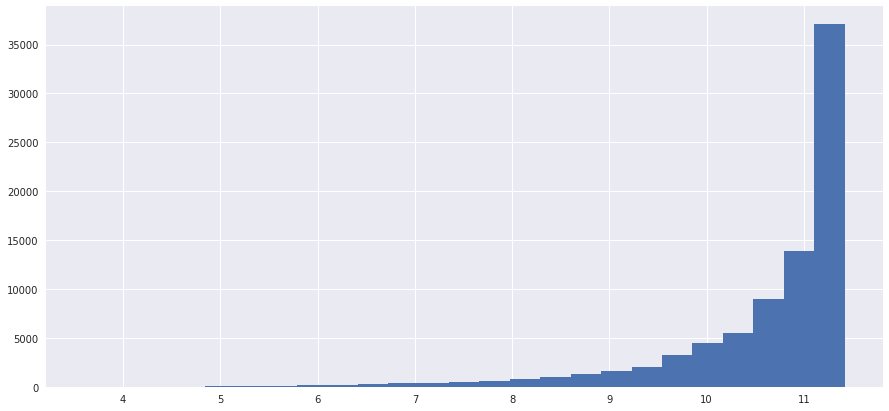

In [10]:
tmp.tfidf.hist(bins=25, figsize=(15,7))

### Model training 

We'll benchmark the following models:

* Logistic Regression, well-fitted for very large datasets, good for very high-dimensional data
* (Multinomial) Naive Bayes, good for very large datasets and high-dimensional data but often less accurate than linear models
* Random Forest, very robust and powerful but not good for very high-dimensional sparse data

#### Splitting dataset 

In [20]:
#Spliting Training and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

X = df.headline + ' ' + df.short_description
le = LabelEncoder()
y = le.fit_transform(df.category)
class_names = list(le.classes_)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index,
                                                                                 stratify=y, test_size=0.3,
                                                                                 random_state=42, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(140597,)
(60256,)


#### Encoding training and test datasets

In [12]:
%%time
# Training Dataset encoded with tfidf
tv_X_train = tfidf.fit_transform(X_train)
tv_X_test = tfidf.transform(X_test)
print(tv_X_train.shape)
print(tv_X_test.shape)

(140597, 56556)
(60256, 56556)
CPU times: user 2min 27s, sys: 418 ms, total: 2min 27s
Wall time: 2min 27s


In [21]:
%%time
# Training Dataset encoded with countvectorizer
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)
print(cv_X_train.shape)
print(cv_X_test.shape)

(140597, 56556)
(60256, 56556)
CPU times: user 2min 30s, sys: 429 ms, total: 2min 30s
Wall time: 2min 31s


Due to the memory limitations of CountVectorizer, we'll also use the HashingVectorizer as an alternative, see [vectorizing-a-large-text-corpus-with-the-hashing-trick](https://scikit-learn.org/stable/modules/feature_extraction.html#vectorizing-a-large-text-corpus-with-the-hashing-trick) for more details

In [39]:
%%timeit
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(ngram_range=(1,2),
                       tokenizer=custom_tokenizer,
                       encoding='latin-1', n_features=50000,
                       alternate_sign=True)
features = hv.fit_transform(df.headline + ' ' + df.short_description)
features.shape

1 loop, best of 3: 2min 7s per loop


In [40]:
features.shape

(200853, 50000)

In [42]:
hv_X_train = hv.fit_transform(X_train)
hv_X_test = hv.transform(X_test)
print(hv_X_train.shape)
print(hv_X_test.shape)

(140597, 50000)
(60256, 50000)


#### Scoring Utility

In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score

def display_scoring(actual, predicted):
  precision = precision_score(actual, predicted, average='micro')
  recall = recall_score(actual, predicted, average='micro')
  f1 = f1_score(actual, predicted, average='micro')
  print("Micro-average quality numbers")
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision,
                                                                       recall,
                                                                       f1))

#### Training a Multinomial Naive Bayes model

In [44]:
# on TfidfVectorizer training set
from sklearn.naive_bayes import MultinomialNB
clf_mb = MultinomialNB(alpha=0.1)
clf_mb.fit(tv_X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [45]:
predictions = clf_mb.predict(tv_X_test)

In [46]:
display_scoring(y_test, predictions)

Micro-average quality numbers
Precision: 0.5724, Recall: 0.5724, F1-measure: 0.5724


In [22]:
# On CountVectorizer training set
from sklearn.naive_bayes import MultinomialNB
clf_mb = MultinomialNB(alpha=0.1)
clf_mb.fit(cv_X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [23]:
predictions = clf_mb.predict(cv_X_test)

In [28]:
display_scoring(y_test, predictions)

Micro-average quality numbers
Precision: 0.5733, Recall: 0.5733, F1-measure: 0.5733


#### Training a LogisticRegression model

In [45]:
# Extracting best model parameters (on the HashVectorizer training set)
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.88,
                            train_size=0.04, random_state=42)
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs = -1)

grid.fit(hv_X_train, y_train)
print("Best cross-validation score : {:.3f}".format(grid.best_score_))
print("Best params : {}".format(grid.best_params_))
print("Best estimator : {}".format(grid.best_estimator_))

Best cross-validation score : 0.386
Best params : {'C': 1}
Best estimator : LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [14]:
%%time
# on TfidfVectorizer training set
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0, random_state=42, n_jobs=-1)
clf.fit(tv_X_train, y_train)

CPU times: user 4min 2s, sys: 1.16 s, total: 4min 3s
Wall time: 2min 4s


In [17]:
#prediction_probas = clf.predict_proba(tv_X_test)
predictions = clf.predict(tv_X_test)

In [28]:
display_scoring(y_test, predictions)

Micro-average quality numbers
Precision: 0.6002, Recall: 0.6002, F1-measure: 0.6002


In [31]:
%%time
# on CountVectorizer training set
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0, random_state=42, n_jobs=-1)
clf.fit(cv_X_train, y_train)

CPU times: user 15min 50s, sys: 64.7 ms, total: 15min 50s
Wall time: 7min 55s


In [33]:
#prediction_probas = clf.predict_proba(tv_X_test)
predictions = clf.predict(cv_X_test)

In [34]:
display_scoring(y_test, predictions)

Micro-average quality numbers
Precision: 0.6035, Recall: 0.6035, F1-measure: 0.6035


### Interpreting the model

#### Confusion Matrix

             precision    recall  f1-score   support

          0       0.36      0.16      0.22       453
          1       0.42      0.11      0.17       402
          2       0.60      0.33      0.42      1358
          3       0.51      0.47      0.49      1781
          4       0.45      0.31      0.37       343
          5       0.63      0.38      0.47      1553
          6       0.58      0.54      0.56      1021
          7       0.77      0.18      0.29       309
          8       0.85      0.69      0.76      1028
          9       0.46      0.25      0.33       301
         10       0.55      0.80      0.65      4817
         11       0.67      0.17      0.27       397
         12       0.60      0.08      0.14       420
         13       0.61      0.76      0.67      1868
         14       0.44      0.10      0.17       419
         15       0.45      0.33      0.38       787
         16       0.47      0.15      0.23      2008
         17       0.74      0.72      0.73   

Text(0.5,159,u'Predicted')

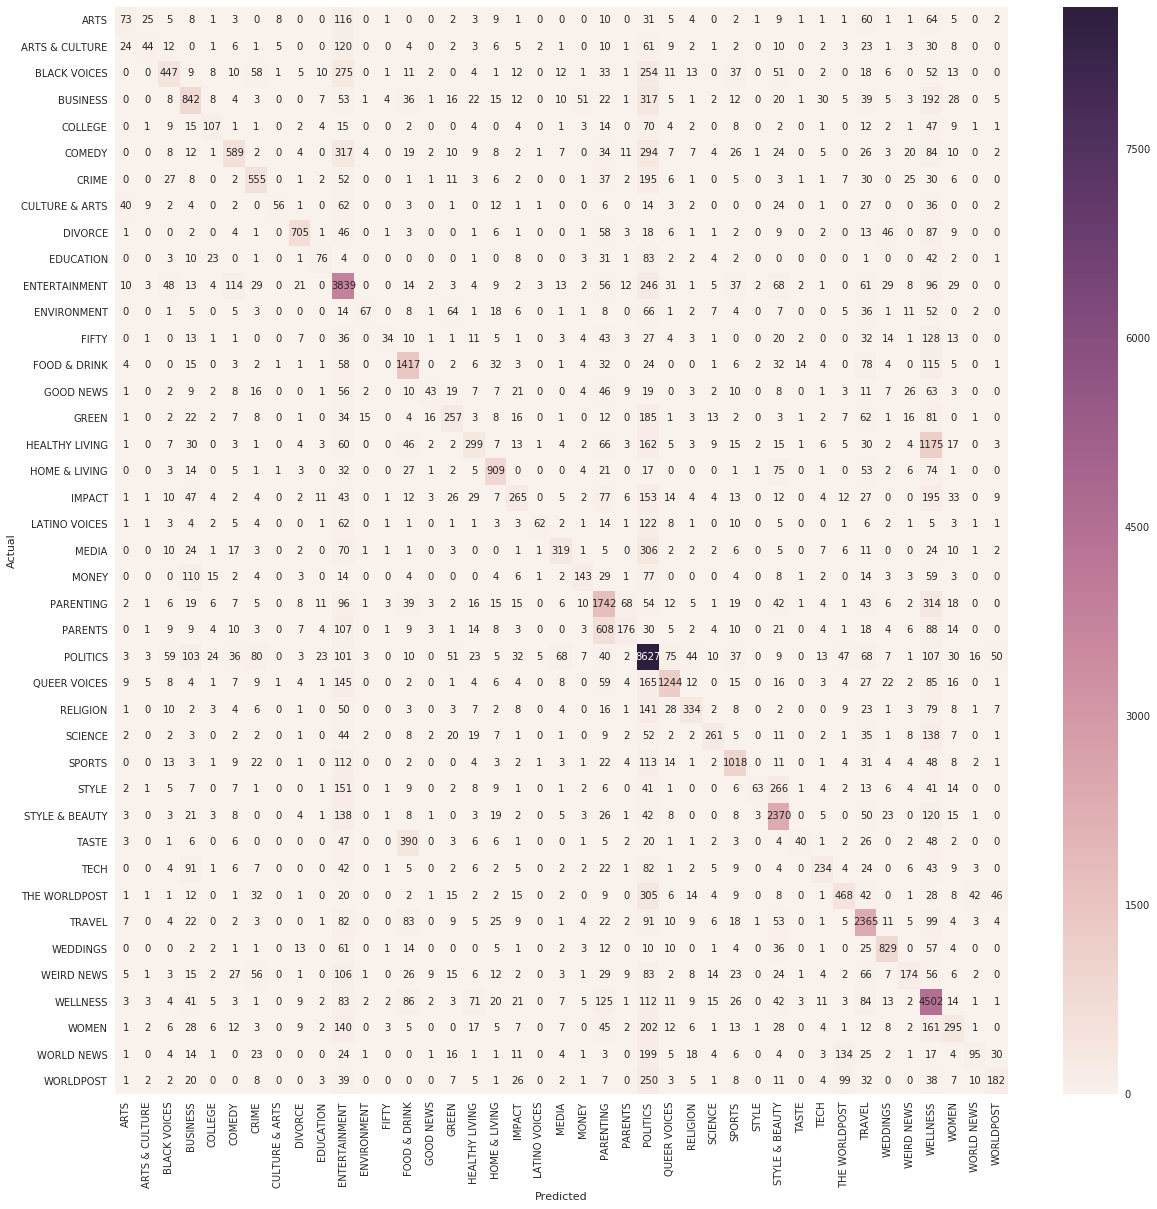

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

print(classification_report(y_test, predictions))

conf_mat = confusion_matrix(y_test, predictions)
print("Confusion matrix:\n{}".format(conf_mat))
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### Investigating misclassifications

In [26]:
from IPython.display import display

for predicted in range(len(class_names)):
  for actual in range(len(class_names)):
    if predicted != actual and conf_mat[actual, predicted] >= 40:
      print("'{}' predicted as '{}' : {} examples.".format(class_names[actual], class_names[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (predictions == predicted)]][['headline', 'short_description']].head(10))

'CULTURE & ARTS' predicted as 'ARTS' : 40 examples.


,headline,short_description
184595,Martin Roemers' 'The Eyes Of War' Provides Str...,Photographer Martin Roemers captured black-and...
153142,"'Sound+Image': Two Artists, a Playlist, Some H...",There has always been an unspoken connection b...
146375,Hyperrealist Artist Painted Eyes Until He Got ...,"​​​​​​​​​​​​​​​​​​​Forget the old saying ""the ..."
126719,A Visit to the Centre for Contemporary Art Uja...,"Last year, the Centre presented an exhibition ..."
174231,Change Is the Only Constant,The word zeitgeist frequently gets bandied abo...
147767,A Behind the Scenes Look Into Putting an Exhib...,"Putting together an exhibit is, frankly, an ex..."
154441,Thomas Williams: Bringing Bay Area Art to London,London-based art dealer Thomas Williams has ma...
127431,And Now for Something Completely Different,"Traditionally, style was the artist's signatur..."
161768,"An Interview with Lebanese artist, Pascal Hach...",PH: Yes same direction - pointing same issues ...
173495,Met Opera: Mozart's 'La Clemenza Di Tito' Exam...,"Passion, jealousy, vengeance, and regicide ret..."


'ENTERTAINMENT' predicted as 'BLACK VOICES' : 48 examples.


,headline,short_description
3070,The Cop In The 'What Are Those?' Meme Loves Th...,"In two interviews, we spoke to the meme creato..."
63029,Yvette Nicole Brown Is Tired Of The 'Sassy' Re...,"""The sassy meter maid, the sassy assistant. I'..."
90304,The Proliferation of Female Inmates and How TV...,"Shows like ""Orange Is the New Black"" (OITNB) a..."
69548,Ryan Coogler Will Direct Marvel's 'Black Panther',The film marks the first time a Marvel movie w...
5014,Kendrick Lamar Wants To Play A Villain In The ...,The rapper is already conquering the music world.
137210,Rebecca Black & Dave Days Party All Day In 'Sa...,"Rebecca Black was so exhausted by ""Friday"" tha..."
75856,Solange Knowles Schools Internet Hater Who Cal...,Beyhive assemble.
81657,"Actor Wendell Pierce on Katrina, Art as Activi...",I spoke with Wendell Pierce - most famous for ...
25739,Racial Bias Allegations Dominate Bill Cosby Ju...,All but two of the 12 jurors are white.
26182,Amandla Stenberg Is Here For Nuanced Portrayal...,"The ""Everything, Everything"" star spoke highly..."


'POLITICS' predicted as 'BLACK VOICES' : 59 examples.


,headline,short_description
73785,Chicago Police Really Didn't Want To Release V...,It took over a year for the video to become pu...
2816,"In Both Rich And Poor Schools, Black Students ...",A new government watchdog report shows how bla...
124475,"Maui, a Paradise of Racial Tolerance?","If Maui is a paradise, it is first and foremos..."
8764,"Steph Curry, Chance The Rapper Join Barack Oba...",🙌 🙌 🙌
88506,"Trade Deal Will Hurt Urban Black Communities, ...",
104375,Who Wants to Talk About That?,Racism is so ingrained in the American experie...
9618,Black Women Are A Political Organizing Force. ...,“Don’t just overlook the hard work that we did...
79424,Black Lives Matter To Speak To 'Unconventional...,Politics and pop culture will mix at first Pol...
23115,Speaking Of 'Rigged',"Within the last two weeks, much of the African..."
47809,"Sandra Bland's Family Got A Settlement, But Th...",Hundreds are still dying in our nation's jails.


'IMPACT' predicted as 'BUSINESS' : 47 examples.


,headline,short_description
105169,Can Social Business Be a Powerful Tool for Lar...,"FEMSA is turning to social entrepreneurship, t..."
131242,The Power of the Private Sector to Save Lives,Good news travels fast. This week's announceme...
88774,Do Corporate Grantmakers Care More About the P...,"For most Fortune 500 companies, philanthropy i..."
127424,Egypt's Women Leaders on the Rise,Recent studies indicate that more women in com...
106747,The Tradeoffs of Tax Dodging,To fund essential services and tackle global i...
107798,Critical Key to Stopping Ebola? Mobile Phones,The impact of mobile applications is growing a...
1343,The Tech Startup Helping Millennial Workers Ta...,"""We’re giving people the tools to represent th..."
81042,Five Ways to Honor the American Worker this La...,The essence of this special day is about ackno...
108670,The Case for a Sustainability Plan in Business...,Our view couldn't be more different. We believ...
105853,The Value of a Toilet: Landlords See Benefit o...,


'MONEY' predicted as 'BUSINESS' : 110 examples.


,headline,short_description
194715,"To Invest Like Warren Buffett, Learn How to Sell",If you want to learn how to invest like Warren...
176026,"Gas Prices Drop 8 Cents In Two Weeks, Accordin...","NEW YORK, Oct 21 (Reuters) - The average price..."
128108,The Single Biggest Problem With Your 401(k),You are already invested in your employer more...
180544,Odd Jobs At The DNC,"Compensate, meaning a free meal. But for a guy..."
190769,Owning Your Company's Stock: A Bad Investment ...,"If we're managing that account, then they're c..."
187537,Asia Now Has The World's Most Millionaires,"Surprisingly, Europe increased its millionaire..."
187556,Awesome Jobs You've Never Heard Of,"Brazen Life: Teacher, Lawyer, Doctor--when som..."
176299,How to Conduct a Networked Job Search,Job fulfillment can be leveraged to assess the...
177128,California Gas Prices To Plunge In The Coming ...,"At one station in West Los Angeles, Rick Lee, ..."
131448,4 Free Tools to Super Charge Your 401k or IRA,The right tool for the right job can make all ...


'POLITICS' predicted as 'BUSINESS' : 103 examples.


,headline,short_description
72823,What to Do About Disloyal Corporations,"In 2013, Pfizer raked in nearly $4 billion on ..."
5713,Bill Gates Warns Tech Giants: Tone It Down -- ...,"“There’s no question of ability,"" says Gates. ..."
102499,Minimum-Wage Increases: The Justice of Redistr...,A stagnant minimum wage redistributes income f...
4190,I Worked In Corporate Accountability For A Dec...,What can consumer pressure campaigns really ac...
3623,Cambridge Analytica Suspends CEO After Alarmin...,The firm's chief data officer will step in as ...
88622,Feds Crack Down On Crowdfunding Projects That ...,
25983,"With Online Sales Booming, States Struggle To ...","While brick-and-mortar stores are closing, onl..."
108711,Paul Krugman: How About A Clinton-Warren Ticke...,
103913,The Waiting Is the Hardest Part: Big Business ...,"If you believe in the minimum wage, then you s..."
46953,A Crooked Wall Street Billionaire Is Crafting ...,Hoo boy.


'TECH' predicted as 'BUSINESS' : 91 examples.


,headline,short_description
60462,Tesla CEO Touts Safety Of Self-Driving Cars,He says they're way safer than human drivers.
135598,An Unlikely Assessment Tool,Decked out in my duct tape bracelet and Camp I...
60806,Elon Musk Wants To Fix Public Transportation,Taking the bus might get a whole lot less terr...
156289,Yahoo Tumblr Purchase Approved By Board: WSJ,Forbes reported on Saturday that Tumblr's boar...
3023,Explosive Facebook Memo Defended Company's Str...,“We connect people. Period. That’s why all the...
70310,Two-Year Cellphone Contracts Are Almost Dead. ...,"Just like T-Mobile and Verizon, AT&T will brea..."
196891,Gazelles and Entrepreneurs: A to M as Fast as ...,"For entrepreneurs, in particular, technology h..."
73895,Your Phone Is Your Secret Weapon For Holiday S...,A number of new apps will let customers order ...
182678,Demystifying SEO for Your CEO,Once a small business CEO recognizes they can ...
176800,Blueseed Raising Money To Park Ship Full of St...,"""How awesome would it be if there could be an ..."


'WELLNESS' predicted as 'BUSINESS' : 41 examples.


,headline,short_description
149651,Working From Home: A Work In Progress,It's now been about six weeks since all Yahoo!...
145665,Weathering a Financial Crisis That's Close to ...,Economic crisis is a time that couples and fam...
129084,"Do You Have a Job, Career or Calling?","One person might say, ""I am laying bricks,"" a ..."
181237,Lantus: Insulin Treatment Could Be Good For Ar...,"Lantus, which generated worldwide sales of nea..."
125537,Consider This Your Reminder To Wash Your Cutti...,None of the cutting boards used to handle non-...
182704,Spiritual Intelligence: Living as Your Higher ...,Spiritual intelligence is critical for persona...
135834,"Yes, You Can Sleep More And Still Be Successful",I'm putting my foot down -- you don't have to ...
155149,Is Entrepreneurship Good For Your Health?,Other steps business owners are taking to cont...
132859,Can Obesity and Malnutrition Co-Exist? The Pro...,Fast food companies are rapidly expanding from...
142187,How to Manage the Two Biggest Distractions,Being able to keep your focus amidst the daily...


'ENTERTAINMENT' predicted as 'COMEDY' : 114 examples.


,headline,short_description
76288,5SOS Abandon All Traces Of Professionalism Aft...,"She meant ""cat,"" guys. Guys, stop."
32278,Stephen Colbert: Trump Tweets More To Attack K...,"""Oh my God,"" the shocked actress said."
110231,Sarah Silverman Talks To Her Younger Self In '...,
73491,This Theory Will Totally Change How You See 'Elf',Christmas is officially ruined.
66186,Heroes Everywhere Are Signing A Petition To Ha...,"It's at 50,000 signatures and counting ..."
25764,Seth Meyers Jokes Trump Has More Contact With ...,The first lady has appeared to dodge her husba...
2493,Cardi B Has Mother Of All Lines About Pregnanc...,"She co-hosted with Jimmy Fallon, but of course..."
20600,Trevor Noah Has A Sad Theory For Why Anthony S...,Noah thinks Donald Trump wishes he was Scaramu...
44643,Miss Piggy Sings A Lauryn Hill Classic In This...,Respect is just the minimum for this wonderful...
34015,Stephen Colbert Says Moby Is Just As Credible ...,And Sean Spicer.


'BLACK VOICES' predicted as 'CRIME' : 58 examples.


,headline,short_description
61420,Trial For Charleston Church Shooter Dylann Roo...,Defense lawyers said a doctor needs two to six...
76996,"After His Car Broke Down, Florida Church Drumm...",Huntsberger said he called roadside assistance...
9471,Teen Used Dying Breaths To Identify Man Who Al...,A police officer testified this week about wha...
63219,Nine Guards Are On Trial For Brutal Beating Of...,Three other guards helped conceal the crime by...
85088,Sandra Bland's Death Will Be Treated Like A Mu...,"""This is being treated like a murder investiga..."
47436,Ohio Police Chief: Senseless Killings By Cops ...,"""I am so sick and drained of some cops doing t..."
91511,Nine Georgia Deputies Fired Over Student's Death,
114453,"Photo Emerges Of Darren Wilson, Cop Who Fatall...",
16715,Chicago Teen Found Dead In Hotel Freezer Spark...,Numerous petitions are demanding justice for 1...
62807,Jury Begins Deliberations In Trial Of Woman Ac...,Cherelle Baldwin faces up to 60 years behind b...


'POLITICS' predicted as 'CRIME' : 80 examples.


,headline,short_description
69940,Denver Inmate's Death At Hands Of Deputies Rul...,Six sheriff's deputies have been placed on res...
59808,Police Are Looking For An Alleged Trump Suppor...,"The assailant allegedly called the woman a ""te..."
33765,Army Vet Caught In FBI Sting Allegedly Plotted...,"Robert Lorenzo Hester, 25, of Missouri, wanted..."
70067,Parents Of Mexican Immigrant Killed By Police ...,Antonio Zambrano-Montes was shot by three patr...
18774,5 Missing After Army Helicopter Downed Near Ha...,A Marine collision last year in the same area ...
87599,"This Mom Lost Custody Of Her Son, Faces Prison...",
79847,"Police Knew Ahmed Didn't Have A Bomb, Arrested...",Sigh.
59540,A Police Officer In This School Allegedly Chok...,The school resource officer was not trained on...
73756,Police Have No Idea How Laquan McDonald Footag...,A Burger King manager says police deleted the ...
75657,Flawed Jury Selection Methods Could Favor Ex-C...,Defense attorneys can be given leeway to choos...


'WEIRD NEWS' predicted as 'CRIME' : 56 examples.


,headline,short_description
105198,This Man Had A Death Wish. For His Mustache.,
115799,Dentist Named Toothaker Allegedly Stole Dental...,
32238,Chilling Video Shows Good Samaritans Saving El...,"“These two individuals, angels themselves with..."
93172,"Florida Cop: 'The Crack Is Not For Me, It's Fo...",
76112,Cats Murdering Toddlers Is A Terrible Person's...,Did you really need more proof your kitty is a...
63829,Man Accused Of Egging Former Neighbor's House ...,"But Jason Kozan, 30, says there are cracks in ..."
16005,Man Tries To Facebook-Shame Police For Bad Par...,Officers in Scotland had the last laugh.
1050,Woman Allegedly Blows Up Pee Sample In A 7-Ele...,The on-duty clerk was pissed.
113439,Prosecutor Allegedly Helped Convict Avoid Jail...,
34938,Man Allegedly Asks Girl Scouts To Trade Vodka ...,Bartering booze for Girl Scout cookies is pret...


'ARTS' predicted as 'ENTERTAINMENT' : 116 examples.


,headline,short_description
97068,Ayoub Qanir Takes Time to Cannes,What do you get when you mix a finance manager...
94031,EverydayClimateChange: Taking a Stand,
89070,How Filmmaker Paige Morrow Kimball Is Helping ...,"With her newest film, Play Date, Kimball wrote..."
96203,"First Nighter: Chenoweth, Gallagher at Full St...",During the On the Twentieth Century revival --...
101080,"'The Marvelous Wonderettes,' San Pedro Theatre...",It's panic time at the 1958 Springfield High S...
115224,Meet The Lady Gaga Of Myanmar,
111493,How The Gotham Typeface Came To Define Our Era,
98810,PhiladelphiaTheatreCo. Celebrates 40 With Star...,The Philadelphia Theatre Company is marking it...
90631,Confessions of a Serial Songwriter: F-F-F-Fifty?,I often say (and you've probably heard me say ...
112133,"Uniquely Asian, Uniquely Modern, Proudly Class...","For its 45th ""Sapphire"" anniversary season, cu..."


'ARTS & CULTURE' predicted as 'ENTERTAINMENT' : 120 examples.


,headline,short_description
29919,"To Make Women’s Stories Prestige TV, Just Add ...",“Big Little Lies” is an honest portrayal of do...
44224,The ‘Bachelor’ Franchise Needs To Stop Giving ...,He's been verbally abusive to contestants. He ...
33664,"This Feminist Film Got Snubbed By The Oscars, ...",“20th Century Women” confronts some hairy issu...
46349,Painting Valued At $26 Turns Out To Be A Rapha...,The Madonna was spotted during the making of a...
53560,Here’s What Happened When We Played Pokémon Go...,The wildly popular video game gets a new look ...
64669,Historical Fiction Gets No Respect -- Here's W...,"Katy Simpson Smith, author of the new novel 'F..."
55557,"'Monopoly: The Musical' To Hit Broadway, Hasbr...",“I can tell you this: It’s not going to be a m...
32821,'White Tears' Is The Horror Story 'La La Land'...,A ghostly mystery haunts a duo of white music ...
85776,"'Meet Me In Montenegro,' And 6 More Beautiful ...",On-the-go movies with plenty of staying power.
29663,Alec Baldwin Calls Out Publisher For Errors In...,"He suggested HarperCollins editors were ""too b..."


'BLACK VOICES' predicted as 'ENTERTAINMENT' : 275 examples.


,headline,short_description
54104,Beyoncé: 'We Don't Need Sympathy. We Need Ever...,The artist posted a powerful statement urging ...
20462,5 Netflix Releases Featuring Black Stars To Wa...,Time to binge!
81145,Cheryl Boone Isaacs To Speak At Women In Techn...,"Cheryl Boone Isaacs, president of the Academy ..."
5731,'Black Panther' Expected To Have Enormous $165...,"The film, which comes out Feb. 16, has already..."
103539,The Big Showdown Episode 3: HBCUs Continue The...,
91851,Jamie Foxx Admits Parts Of His National Anthem...,
4275,Michael B. Jordan Says His Company Will Adopt ...,Frances McDormand memorably called for inclusi...
62872,Billy Dee Williams Returns As Colt 45 Spokesman,Colt 45 is targeting its glory days with the r...
46866,Singer And Producer Kashif Has Died,"Singer and producer, Kashif Saleem, known as s..."
80570,"Melle Mel Calls Out Jay Z, Kendrick Lamar In D...",Macklemore & Ryan Lewis’ performance at the 20...


'BUSINESS' predicted as 'ENTERTAINMENT' : 53 examples.


,headline,short_description
121521,"Millennials as Smart, Highly-Adaptive ""Reptiles""",
116132,This Is The Way 'Williamsburg' Ends,
151113,An Entrepreneur in Venice: An Interview With M...,"Like both his grandfather and father before, M..."
3644,Weinstein Company Files For Bankruptcy After S...,The embattled film studio said Monday that it ...
57611,How Game of Thrones and Startups Are Similar,
64275,The Financial Crisis Film 'Boom Bust Boom' Fal...,Our biases nearly always get the best of us.
95774,New Internet Radio Station Modeled on Heyday o...,"In the birthplace of Rock and Roll, a radio st..."
159077,West Fertilizer Co. Failed To Disclose It Had ...,"In its RMP filings, West Fertilizer reported o..."
60182,Comcast To Acquire DreamWorks Animation For $3...,"The studio behind ""Shrek,"" ""Madagascar,"" and ""..."
178035,The Real Returns of Mobile ROI,"Mobility, especially in the convergent world, ..."


'COMEDY' predicted as 'ENTERTAINMENT' : 317 examples.


,headline,short_description
63340,"Every Time A Pikachu Dances To ‘Formation,’ A ...","""Thanks for this!"" - Your eyes and ears."
1691,"Watch Out Alec Baldwin, These Kids' Donald Tru...",Nailed it.
65990,Donald Trump In 'Game Of Thrones' Is Exactly W...,Mashup drops presidential candidate right into...
94408,B Is for...,
66388,"Welp, 'The Revenant' Featuring Bob Ross Isn't ...",No happy trees here.
99448,Back to the Future,
157699,Australian 'Star Wars' Parody Brings Luke To T...,"Stuntbear brings us a reenactment of ""Star War..."
66253,Will Ferrell's Shout-Outs Are The Embodiment O...,That's how it's done.
31427,Comedian Releases Song To Find Her Own Rachel ...,“Just want to hear your political opinions and...
88706,Amy Poehler Is Really Good At Sports Chatter,


'CRIME' predicted as 'ENTERTAINMENT' : 52 examples.


,headline,short_description
86567,'Oohs' And 'Ahs' Turn to Panicked Screams As F...,
63356,Angry Customer Unleashes 13-Foot-Long Python I...,Maybe he just should've left a bad review on Y...
10971,'Glee' Star Naya Rivera Charged With Domestic ...,Husband Ryan Dorsey says she struck him on the...
135451,Sister Baffled By Alex Johnson's Sudden Disapp...,Cayce Johnson said the authorities have assure...
4411,Fyre Festival Founder Faces Prison After Plead...,“I grossly underestimated the resources that w...
117275,Twin Sisters Charged With Prostitution,
106665,The $11-Million Manhunt,
114695,MMA Fighter Arrested For Alleged Assault On Po...,
116690,37 Tons of David Victorson: A Tale of Ballsy R...,"""In a time of universal deceit,"" George Orwell..."
1617,Patton Oswalt Celebrates Michelle McNamara's L...,"“I think you got him, Michelle."""


'CULTURE & ARTS' predicted as 'ENTERTAINMENT' : 62 examples.


,headline,short_description
141224,Somali Pirate Movies Take Hollywood,"Of course, what he calls ""movieness"" still per..."
171646,Psy Apology: 'Gangnam Style' Singer Apologizes...,"""I will forever be sorry for any pain I have c..."
174155,'Sleep Song' At Harlem Stage Gatehouse Tells T...,Poet-musician Mike Ladd's new piece is called ...
166445,Crowdfunding 201: A New Model From Seed & Spark,"Enter Seed & Spark, a (very) new entrant in th..."
139143,Reflections on Eddie Peake's Performa 13 Commi...,"On Thursday, I had the pleasure of seeing Eddi..."
176167,'Alan Cumming Snaps!': The 'Good Wife' Actor's...,When he's not destroying political enemies as ...
141825,"Totem, Cirque du Soleil, San Pedro, CA",If you could amend the Nobel Prize charter to ...
160354,Before the Parade Passes By,"If one is lucky, certain theatrical moments re..."
163661,A Rare Charlotte Brontë Manuscript Up for Auction,The manuscript of a poem by Charlotte Brontë i...
135517,Woody Allen Is Zhenya Gershman's 'Sunny Side Up',Woody Allen's films have global meaning across...


'DIVORCE' predicted as 'ENTERTAINMENT' : 46 examples.


,headline,short_description
157911,Charlie Sheen Defends Denise Richards' Weight ...,Denise Richard got flak from the media last we...
143094,Katy Perry: How Do You Find the Light in the D...,Behind her colorful and bubbly pop personality...
132791,15 Movie Titles That Describe Your Completely ...,Scroll through the slideshow below for even mo...
140175,15 Things Bruce Jenner Can Do Now That He's A ...,5. Drink more than two beers. 11. Save some mo...
160637,"Porsha Stewart, Kordell Stewart: 'Real Housewi...","On Wednesday, ""Real Housewives of Atlanta"" sta..."
178771,Emmy Nominees 2012: What These Stars Have In C...,This year's Emmy-nominated actors and actresse...
171581,John Lennon Death Anniversary: A Look Back At ...,"In 1969, when The Beatles were parting ways, J..."
165945,"LeAnn Rimes, Brandi Glanville: Country Singer ...","Brandi Glanville's tell-all book ""Drinking and..."
173764,Kid Rock 'Rebel Soul': Musician Opens Up About...,"“[The relationship] started to affect my son, ..."
191210,Chris Harrison Divorce: Will He Be The Next Ba...,"In February 2010, Harrison denied accusations ..."


'FOOD & DRINK' predicted as 'ENTERTAINMENT' : 58 examples.


,headline,short_description
125571,"When Julia Child Gives You Advice, Take It","Fourteen years ago, Julia Child gave me the be..."
154836,"Jell-O, Why Are You So Gross?: A Dear John Letter",We've had enough of your wiggle and jiggle.
126841,Drink Like A Genius God This Weekend By Channe...,That's Kanye motherf****** West.
129592,9 Clever & Delicious Best Picture Themed Oscar...,This year the Best Picture category gave me a ...
198293,9 Dazzling Oscar Night Menus,We bow to the over-the-top fizzy silliness tha...
129544,7 Glamorous Drinks for Your 2014 Oscars Party,"As you watch the Academy Awards, be sure to mi..."
157256,7 Things You Need to Do Right Now to Get Ready...,Seven things you need to do right now to get y...
161997,Justin Timberlake Sandwich By HooplaHa: Put On...,The creators of the Beyoncé Sandwich are back ...
149235,Chip Clip Bag Resealer Keeps Your Snacks Fresh,This chip clip is the real deal.
142733,Frozen Tater Tots? No Shame In That Game,Sometimes the easiest thing is the best thing.


'GOOD NEWS' predicted as 'ENTERTAINMENT' : 56 examples.


,headline,short_description
54655,This Family Of Surfing Pigs Is A Pixar Movie W...,This little piggy went to the beach...
49741,"Teen Recreates Old Photo For School ID, Slays ...",This is the throwback to end all throwbacks.
53734,Disney Emojis Are Coming Soon And They're Game...,Prepare for texts filled with Buzz Lightyear.
72259,There's Way Too Much Cuteness In This New Dog-...,How will your canine companion score?
43595,Hundreds Of Scarves Hung In Veterans' Park To ...,Tis the season.
84812,The Best Friend Ever? Meet A 9-Year-Old Bracel...,Rubber band jewelry can be a force for good.
53215,Manatee Drops By To Say Hi To Girl On A Paddle...,"He’s not sure how to say this, but around thes..."
111529,Daniel Radcliffe Pays Back Cab Fare 2 Years Later,
53324,Chris Pratt’s Son Is Adorably Diplomatic About...,🙊🙊🙊
55588,'Chewbacca Mom' Scores Her Own Laughing 'Star ...,The Wookiee toy features 13 catchphrases inclu...


'HEALTHY LIVING' predicted as 'ENTERTAINMENT' : 60 examples.


,headline,short_description
115660,Story Time!,
55231,Hey Procrastinators: When You Get Around To It...,Here's something you probably aren't doing whe...
124136,"Anna and Darius: Los Angeles -- April 20, 2014",
23397,How Not To Be Boring,"Fortunately, the gift of being interesting is ..."
104327,Why Surgeons Listen To Music In The Operating ...,
22443,The Man Behind The Ice Bucket Challenge Is 'St...,"Pete Frates, 32, just shared a video of himsel..."
31098,Welcome To The Grief Club,Death is not a dress rehearsal. Death is final.
102100,Which Wolf Will You Feed in 2015?,
43791,Zayn Malik Gets Candid On Why He Chose To Talk...,Nailed it.
27300,What You Need To Know About Online CPR And BLS...,It may take five or more minutes before an eme...


'IMPACT' predicted as 'ENTERTAINMENT' : 43 examples.


,headline,short_description
124376,Man Breaks It Down Once And For All Why You Sh...,
63476,The Cast Of ‘Game Of Thrones’ Team Up To Raise...,"Over the past five seasons of Game of Thrones,..."
170247,"What Was It Really Like -- That ""Silent Night""?","Its lyrics are known to countless millions, an..."
16850,How A Houston Mosque Became A Harvey Disaster ...,As we keep our eyes peeled on the latest track...
65146,Lady Gaga's Oscars Performance Is Inspiring Su...,Lady Gaga invited dozens of survivors of sexua...
104523,"Calling All Harry Potters, Bilbo Baggins and K...","So come on all you Bilbo Baggins, Captain Ahab..."
55954,Anne Hathaway Named UN Goodwill Ambassador,The actress is going to focus on promoting aff...
121072,WATCH: Franklin Project's 'Summit at Gettysburg',
82020,How One Actress-Activist Is Working To End Dog...,Rebecca Corry hopes a new tip line will help l...
92526,How Bruce Jenner's Story Allowed Me to Finally...,After seeing Bruce Jenner's outstanding interv...


'LATINO VOICES' predicted as 'ENTERTAINMENT' : 62 examples.


,headline,short_description
67154,Alejandro González Iñárritu On Donald Trump An...,Alejandro González Iñárritu nabbed the Directo...
71457,Miss Colombia Gracefully Responds To Steve Har...,"Well, she's beauty and she's DEFINITELY grace."
20993,Demi Lovato Throws A Star-Studded Pool Party F...,"Paris Hilton, Wiz Khalifa, and Jamie Foxx are ..."
46057,Jennifer Lopez And Marc Anthony Are Working On...,"Yes, you read that right."
46894,Gina Rodriguez Rapping Nicki Minaj's 'Super Ba...,The actress dropped some serious bars.
6382,Lin-Manuel Miranda And Vanessa Nadal Welcome T...,"The ""Hamilton"" creator even shared a photo of ..."
83941,Robert Rodriguez Wrote 'From Dusk Till Dawn' R...,"""I threw out that we'd love to put her in some..."
46029,There's Going To Be A Concert On The U.S.-Mexi...,It'll be a star-studded affair and free!
8069,Eva Longoria Confronts E! Over Pay Inequality ...,Debra Messing wasn't the only actress who expr...
46434,What Casting A Latina On SNL Means For The Res...,"We are a people who, unfortunately, have gotte..."


'MEDIA' predicted as 'ENTERTAINMENT' : 70 examples.


,headline,short_description
99576,MAD Magazine Enters a New Era of Star Wars,
113672,I Love My Radio: My Stroll With Owen Bennett-J...,After twisting both knobs back and forth for a...
70322,'The Meredith Vieira Show' Canceled After Rati...,"""We promise to spend our final weeks producing..."
8320,How Logan Paul's 'Dead Body' Video Explains Th...,The internet celebrity's post is gone. What's ...
114293,Fareed Zakaria Accused Of Plagiarism,
56709,Behind Peter Thiel's Plan To Destroy Gawker,"It’s voting season for the Emmy Awards, which ..."
10012,Powerful Gossip Editor Dylan Howard Was Also I...,"“Right off the bat, he made every woman in the..."
13011,NBC Fires Mark Halperin Following Sexual Haras...,At least a dozen women have publicly accused h...
6154,Tronc Sold The Los Angeles Times To Billionair...,The sale comes amid turbulence between Tronc a...
11280,"CBS, PBS Cut Ties With Charlie Rose Following ...",At least a dozen women have accused Rose of un...


'PARENTING' predicted as 'ENTERTAINMENT' : 96 examples.


,headline,short_description
168968,"Baby Loves Classic Rock, Especially The Beatle...",Some babies sing Adele. Others dance to Beyonc...
172555,Should Little Girls Have Secrets?,"""Well, you know, Molly, I don't like secrets. ..."
143611,Kristen Bell On Her Post-Baby Body: 'I Have A ...,"Bell explained, ""Look, I'm like any other woma..."
171699,Dads Sing 'All I Want For Christmas Is You' By...,What the stars of many cute pop song covers la...
154284,'Honest' Disney Movies: What Popular Kids' Fil...,Nothing in life is as simple and straightforwa...
143456,"Convos With My 2-Year-Old Season 2, Episode 2:...","Sometimes, making the bed is about more than j..."
173596,Why I Created Sofia The First,"I saw that my son, Miles, could use a fantasy ..."
181875,Why I Refuse To Watch 'Honey Boo Boo' -- And H...,"""What do you think about Honey Boo Boo?"" the p..."
152944,Too Legit Too Cute: Rap Onesies,I saw on Twitter were someone had been stopped...
167194,The Birthday Party I Don't Take for Granted,"Last year at this time, the birthday party wou..."


'PARENTS' predicted as 'ENTERTAINMENT' : 107 examples.


,headline,short_description
110680,Fall Movies Every Mom Will See,Rather than feel a little sad for yourself whe...
98983,I'm In My Golden Age Of Mothering,"Golden ages are characterized by stability, ha..."
19587,11-Year-Old Boy Stuns Idina Menzel With Show-S...,WOW!
93391,Our First Sonogram,Oh my gosh! I could see a teeny little light f...
31262,Ellen DeGeneres Shares Hilarious Trump-Inspire...,"""The The Lion The Witch And The Microwave That..."
13953,11 Inspirational And Heartwarming Reads For St...,Stepparenting 101.
21335,Hilary Duff Shared This Moving Poem That's Res...,Poet Rachel Zucker's take on parenting struck ...
44182,Watch This Fierce Little Girl Take Down The Mo...,#WhoRunTheWorld
40554,Chris Pratt's Son Is Totally Trolling Him,"""No, I'm the guy!"""
14585,"Jenny Mollen Posts 'Chic' Postpartum Photo, An...",The actress and author welcomed her second chi...


'POLITICS' predicted as 'ENTERTAINMENT' : 101 examples.


,headline,short_description
15922,An Empire Of Madness: My Version Of Our World ...,Sometimes it’s hard to believe that my own cou...
43801,Al Franken Sings 'Itsy Bitsy Spider' To Soothe...,Who says there aren't perks in coach anymore?
73961,Obama's 'Amazing Grace' Rendition Sampled On N...,How sweet the sound.
87180,Looking Good!,
30268,The Death Of The Queen Is Going To Be So Much ...,The Guardian's Sam Knight shows us how the wor...
110881,What's the Exit Strategy?,What's the Exit Strategy?
52057,Jennifer Granholm Channels Carly Simon To Mock...,"""Donald, you’re so vain. You probably think th..."
75427,John Bel Edwards' New Ad Attacking David Vitte...,Can you guess what aspect of David Vitter's ch...
25139,Off With Her Head!,"So, comedienne Kathy Griffin’s head appears to..."
80047,Jon Stewart and 9/11 Responders Walk The Halls...,"""It's kind of crazy that we're here begging. I..."


'QUEER VOICES' predicted as 'ENTERTAINMENT' : 145 examples.


,headline,short_description
66009,The 'Danish Girl' Creative Team Share Their Ex...,The film's writer and director reveal why Lili...
43779,'Quantico' Star's Musical Tribute To 'Hocus Po...,Jay Armstrong Johnson put a spell on NYC just ...
4030,Ellen DeGeneres Reveals That A Girlfriend’s Tr...,And it all began with the thought: “Why is thi...
16694,"Musicals, Madness, and Memory.",Part 1 - When a Musical is More Than a Broadwa...
34932,John Early And Kate Berlant Are The Comedic Du...,The politically-charged entertainers discuss t...
18474,Frankie Grande Pays The 'Indoor Boys' A Surpri...,A passive-aggressive hookup goes awry on the s...
68984,Could Luke Skywalker Be Bisexual? Mark Hamill'...,"""You can decide for yourself."""
90074,Would You Rather: Max Rockatansky Or Nux From ...,
426,Singer Ryan Amador Says 'Loverboy' Is His 'Sec...,"He looked to ""Call Me by Your Name"" to visuall..."
80281,Here's Why Kristen Stewart Feels 'Really Bad' ...,"""'Oh, buddy, that must suck.'"""


'RELIGION' predicted as 'ENTERTAINMENT' : 50 examples.


,headline,short_description
115216,Cheek Turning: Completely Impractical Words Je...,But here's the question I cannot escape: How d...
104018,Black Ribbon in the Balsam,The ribbon was there every year to remind us t...
106624,Biblical Abraham To Be Tried For Child Endange...,
14545,The God Of CSI: Las Vegas,"Means, motive, opportunity. For detectives, na..."
100591,'American Sniper' Made Some Fans 'Wanna Go Sho...,
117822,'I'm So Hungry' Iggy Azalea Parody Is The Rama...,
32777,Every Episode Of Reza Aslan's 'Believer' Will ...,"""At one point or another, everyone’s going to ..."
36291,The Secret Behind Her Smile: Mary Tyler Moore,"In reporting her death, Mary Tyler Moore’s pub..."
124611,British Priesthood Uptick,
75443,Pope Francis Just Released A Pop-Rock Album,Italy rejoice!


'SCIENCE' predicted as 'ENTERTAINMENT' : 44 examples.


,headline,short_description
94976,A CD Shattering Into Smithereens Is Surprising...,
74819,This Astronaut's Bagpipes Performance Is Out O...,"He played ""Amazing Grace"" as a tribute to his ..."
70631,"Sorry, But Cinderella's Glass Slippers Would'v...","Also, spoiler alert, magic owls are magic."
94616,Here's Where To Marvel At The 'Blood Moon',
101638,Beethoven May Have Composed Masterpieces To Hi...,
98142,Manx's Surprising Revival,Manx--the ancient Celtic tongue spoken on the ...
141787,Martin Gardner -- The Best Friend Mathematics ...,"What do L. Ron Hubbard, H.G. Wells, G.K. Chest..."
118380,Here's How Independence Day Is Being Celebrate...,
93031,Creature Of Sea Monster Legends Washes Up Near...,
72041,"An Eerie, Jupiter-Like Storm Is Raging On This...",This giant whirlwind has lasted for two years ...


'SPORTS' predicted as 'ENTERTAINMENT' : 112 examples.


,headline,short_description
57407,Bethany Hamilton Pulls Off Huge Upset In Fiji ...,The shark-attack survivor and new mom proves y...
74984,Kobe Hired A Film Crew And We’re Supposed To P...,"WAKE UP, SHEEPLE."
5885,"Johnny Weir Says He's A Commentator, Not A 'Co...",NBC's Olympic figure skating analyst explained...
52349,Ryan Braun Wants To 'Retire At A Young Age',"""I mean, it’s impossible not to think about at..."
42898,Tom Brady Says Gisele Bundchen Told Him To Shu...,The right call.
80897,IndyCar's Scott Dixon Reflects On His Latest C...,"""Justin was always looking out for other people."""
82063,Houston Astros Mascot Resurrects The 'Single L...,Now will the Astros put a ring on it later thi...
63701,We’ve All Been This Adorable Crying Dayton Fan...,"In other words, we feel you, kiddo."
17894,Twitter Really Couldn't Handle Mayweather's Fi...,"Even ""Grey's Anatomy"" star Jesse Williams coul..."
36000,Royal Rumble Winner Rumors! Will Kenny Omega M...,


'STYLE' predicted as 'ENTERTAINMENT' : 151 examples.


,headline,short_description
16308,All The Best Looks From The Emmys Red Carpet,"We can't tell a ""Big Little Lie,"" everyone loo..."
24526,All The Harry Potter Makeup You Need To Look A...,Works like a charm ✨
100495,"Kristen Wiig, We Need Your Sneakers!",
41916,Ciara Shows Off Baby Bump In A Skintight Black...,She's literally glowing.
47291,These Sparkly Geode Lips Are About To Rock You...,Simply stunning.
99151,Miley Cyrus Looks Surprisingly Sophisticated A...,
99160,Iggy Azalea's Gown Has The Most Perfectly Plac...,
72984,Amal Clooney's Silver Crop Top Is Holiday Part...,This is not your average December look.
31971,Lorde Dressed Like A Moth On 'Saturday Night L...,This is pretty perfect.
85554,Balmain Celebrates Stunning Sisters In New Cam...,It looks like the Balmain army is taking over ...


'STYLE & BEAUTY' predicted as 'ENTERTAINMENT' : 138 examples.


,headline,short_description
171284,Eva Herzigova Pregnant With Third Child At 39,We did not see that one coming.
199940,"Ke$ha's Makeunder, Joan River's 739 Cosmetic P...",Get out. Joan Rivers claims she's had had 739 ...
127379,We Bet Reese Witherspoon Regrets This '90s Hai...,"Happy 38th birthday, Reese! Here's to better h..."
146028,Russell Brand Blasts Hugo Boss For Nazi Ties A...,"Later on in the night, Brand was allegedly kic..."
130812,Jared Leto Shows Up Late To Jeremy Scott Runwa...,About 35 minutes after Jeremy Scotts' Fall 201...
198650,"Lana Del Rey Performs For Mulberry, Lindsay Lo...","Lindsay Lohan has been asked to host ""Saturday..."
126891,Zoe Saldana Is The New Spokesmodel For L'Oreal...,"According to E! News, actress Zoe Saldana will..."
199810,"Sissy Spacek in ""Badlands"": The Unexpected Icon",I am perhaps the last person on earth to see T...
129179,Chrissy Teigen Is A Sleek Goddess At The Oscar...,Mrs. John Legend arrived at the Oscars on Sund...
140502,There Was A Miley Cyrus Hashtag On Halloween B...,"Just in case you were wondering: Yes, there wa..."


'TASTE' predicted as 'ENTERTAINMENT' : 47 examples.


,headline,short_description
85784,'The Simpsons' Duff Beer Will Soon Be A Reality,"""The Simpsons"" studio 21st Century Fox is givi..."
92834,Taco Bell Returns To Japan After Decades-Long ...,
13024,16 Sinful Sweets For Your Boo Bash,Halloween and caramel go hand-in-hand.
93072,Meat as a Seasoning,
12246,People Are Boycotting Jim Beam Because Of Some...,The brand's spokesperson is causing quite a stir.
114941,Adam Richman Defends His Support Of Walmart Beef,It's what's for dinner on this TV host's table.
22784,Luke From 'Gilmore Girls' Is Getting His Own L...,We have a feeling Lorelai would've loved this.
60469,Hi-C's Ecto Cooler Is Officially Coming Back F...,Bustin's about to feel good again.
28380,"Beware, The Dragon Frappuccino Is Coming For Y...",RAWR. 🐲
54008,"Bunch Of Grapes Sells For Nearly $11,000, Beca...",The grapes are the size of ping pong balls and...


'TECH' predicted as 'ENTERTAINMENT' : 42 examples.


,headline,short_description
85760,Here Are 7 Unforgettable Quotes From Nintendo'...,Colleagues and friends remember him as a gamin...
77423,Netflix Gained 3.6 Million More Subscribers In...,Netflix has picked up 16 million more subscrib...
153037,WATCH: Content Shines at Cannes,The big winner at the Cannes Lions Internation...
57230,'Finding Nemo' Told With Emoji Is Pretty Freak...,"Disney, you've made us squee yet again."
60994,Amazon Actually Beats Netflix In The One Area ...,Maybe it's time to rethink that subscription.
48203,Instagram Is Now Letting Everyone Moderate The...,We'd double-tap this.
76066,SXSW: 'We Made A Mistake' Canceling Online Har...,The festival wants to compensate with a full-d...
177376,The World of 'Makers' Revealed by Wired's Chri...,Chris Anderson has cemented himself as the pre...
74790,Snapchat Users Don't Want To Start Paying For ...,The good ones cost 99 cents.
72578,Magic Printer Produces Its Own Paper,This is the most exciting an Epson product has...


'TRAVEL' predicted as 'ENTERTAINMENT' : 82 examples.


,headline,short_description
122391,Fine-Tuning Our Tour Program,
157369,The Contradictions of Austin,Austin's strange mixture of cultures and ideol...
189609,Kim Kardashian Twitter: Celeb Takes On British...,Check out more celebs who have had run-ins wit...
125406,27 Things You'll Miss About America When You'r...,"2. Ice. Ice, BABY. 7. The TV shows (sorry Down..."
184552,Apollo 11 Flight Director Gene Krantz Explains...,Stout and brawny and still looking like a mari...
156831,"Wild Night Ride Fueled by Pot, Puke and the Dead",By the time we made it to a rest stop and a Mc...
114710,Andrew McCarthy Gets Behind The Wheel At Dream...,
145325,Sumatra's Vivid Red Orangutans in their Final ...,"High in the branches, a vivid orange-red blur ..."
145032,Fall TV Premieres That Make Us Want to Travel,It's the most wonderful time of the year for t...
166301,Born to Explore: Rhinos In Jeopardy (PHOTOS),I've always sensed that Alex Trebek and his sh...


'WEDDINGS' predicted as 'ENTERTAINMENT' : 61 examples.


,headline,short_description
143377,It's Official: Aaron Paul Is The Greatest Husb...,"4) ""I'm the luckiest man on the planet. It doe..."
168073,Wedding Songs: The Most Romantic Songs To Add ...,This Spotify playlist includes music from the ...
163206,Is 21 Too Young to Marry?,My first instinct was to tell her that she's t...
175857,On Becoming A Wife: Thoughts From a Fiercely I...,It was the dream I had last night -- the candl...
184448,More Young Stars Are Marriage Bound - Latimes.com,Miley Cyrus likes to spend her days playing wi...
185680,We Introduced the Same Husband to Each Other,What we couldn't possibly have known was that ...
190065,"Left At The Altar: Steven Silverstein, Jilted ...",And it doesn't seem like this conflict will be...
151229,Movie Trailer Proposal: Man Proposes in Movie ...,After Matt Still's movie trailer proposal went...
187383,Chris Harrison: Jennifer Aniston Would Make A ...,Would Justin Theroux get the final rose? Chris...
126687,50 Ways To Turn Your Big Day Into A Superhero-...,"From Captain America to Spider-Man to X-Men, t..."


'WEIRD NEWS' predicted as 'ENTERTAINMENT' : 106 examples.


,headline,short_description
94956,New Zealand Weed Shortage Is Dire,
110201,This Woman's Polyphonic Overtone Singing Sound...,
53408,82-Year-Old 'America's Got Talent' Star To Roc...,“We’ll see the bodies hit the floor in the pit...
115194,Man Builds 'Star Trek'-Themed Cabin Out Of Junk,
93291,Chiropractor Performs Exorcisms And Barters Fo...,
37669,Man Who Says He Changed 'Hollywood' Sign To 'H...,“It was something to smile and laugh out loud ...
13967,Jim Bakker Says God Will Punish You For Making...,"""I warned you but you didn’t listen."""
59263,Oh Yeaaaaah! Meet The Voice Of The Kool-Aid Man,Actor and singer Frank Simms also sang backgro...
47506,Badass Cow Takes Down Helicopter And Walks Off...,Beware of the... cow?
71784,Star Trek Fans Think This Woman's Holiday Flai...,"""Make it sew."""


'WELLNESS' predicted as 'ENTERTAINMENT' : 83 examples.


,headline,short_description
143537,For Joel at 94,I wrote this poem a few years ago to honor a f...
166026,Fitness Instructors Are The New DJs,Devin Murphy loves the new remix of the 1984 B...
129378,"All Right, All Right, All Right!",When I watched Mr. McConaughey's Golden Globes...
163604,The Top 10 Workout Songs for March 2013,"Put simply, there weren't a lot of pop songs t..."
179412,How To Pick The Best Mattress,"Thanks to Joyce Walsleben, David M. Rapoport a..."
178673,Best Compliments Ever: The Kindest Words You'v...,"Last week, Oprah.com columnist Leigh Newman ga..."
199025,Rage -- Coming Soon From a Narcissist Near You,There is a saying that when you're a hammer th...
187062,What's in Your God Box?,"Last month, I had the deep pleasure of speakin..."
125387,"The Great Instagram Outage Of 2014, Explained","Now that it's over, and we can look back on th..."
153303,The Workouts That Shape Hollywood,"Take one look at the well muscled, well toned ..."


'WOMEN' predicted as 'ENTERTAINMENT' : 140 examples.


,headline,short_description
11468,Gabby Douglas Says Dressing Provocatively 'Ent...,"She apologized to fellow Olympian Aly Raisman,..."
110113,What Emma Watson's U.N. Speech on Feminism Mea...,While our beloved celebrities may win awards f...
30859,#MuslimWomensDay Takes Off On Twitter Amid Cel...,The trolls were out on Twitter as Muslim women...
43655,Mila Kunis Is 'Done Compromising' Because Of W...,Round of applause 👏
100978,"5 Perfect Quotes From HBO's 'Girls' Season 4, ...",
1312,Cate Blanchett Says Harvey Weinstein Sexually ...,The actress also expressed support for Dylan F...
59465,Best Coast Singer On Sexual Harassment: ‘It’s ...,"""It doesn’t exist just in my industry."""
30439,China's First Androgynous 'Boy Band' Is Breaki...,Acrush is making fans across China swoon.
107627,Why Amy Poehler's Candid Career Advice In 'Yes...,
41368,Moroccan TV Airs Beauty Tutorial On How To Hid...,Just WTF.


'HEALTHY LIVING' predicted as 'FOOD & DRINK' : 46 examples.


,headline,short_description
86994,What You Eat Isn't What You Get: The 6 Troubli...,
105747,6 Tiny Tweaks To Make Your Thanksgiving Recipe...,"By all means, eat your heart out!"
89968,Raise Your Glass,
24354,Why I Quit Drinking,“My mother was a drunk” is one of the harshest...
88226,Palatetraining: Parents Aim to Buy the Best Fo...,
118083,This Video About Worry Will Really Make You Think,
70979,6 Food Trends To Help You Eat Better In 2016,"Get ready for power bowls, spiralized veggies,..."
7927,27 Perfect Tweets About Whole30 That Will Make...,"""The only Whole30 I want to participate in is ..."
108337,How To Cook With Pumpkin That Doesn't Come Fro...,
90743,6 Foods That Can Make You Happier,


'TASTE' predicted as 'FOOD & DRINK' : 390 examples.


,headline,short_description
54381,The Poke Bloody Mary Is The Brunch Mashup You ...,Before you freak out about throwing raw fish i...
26009,"From Bulgaria to East Asia, the making of Japa...",One of Japan’s biggest food trends right now i...
23103,Chill Out: 5 Fun Frozen Summer Sweets,The beauty of banana ice cream is that it’s na...
109453,New Social Network Promises To Serve Up 'The U...,Obsessively 'gram every meal? This new social ...
100010,This Homemade Ranch Mix Lets You Make EVERYTHI...,This is a game changer.
39704,From Chocolate Peanut Butter Pie To Ricotta Ch...,
93410,The Best Low-Calorie Mixers to Use Now,Drinking healthy to most people means vodka so...
106401,Why People Are Eating Bowls Of Beans For Break...,"Beans, beans, the magical breakfast fruit."
28507,10 Of The Most Instagram-Friendly Ways To Drin...,Never open a bottle just to drink one or two g...
114380,This Competitive Eater Made And Ate A Cookie D...,The cookie dough bowl weighs a whopping 18 pou...


'TRAVEL' predicted as 'FOOD & DRINK' : 83 examples.


,headline,short_description
178360,Forget Sushi: 10 Other Foods To Eat In Japan,Sushi--a term that actually refers to the spec...
199111,"Girls' Night Out: Six Women Chefs, Three Dinne...",If you are interested in food and are going to...
195991,Afternoon Tea At The Burj Al Arab (PHOTOS),We begin with champagne and a cup of tea chose...
179987,10 Great Roman Dishes,"Despite the city's imperial pedigree, Roman cu..."
157872,What to know before you go to Cuba,What are the people like in Cuba? No vaccinati...
148124,Pastry Chefs Reveal Their Favorite Desserts Ar...,"Pastry chefs like Dominique Ansel, François Pa..."
153542,London Restaurant Notes: Dinner by Heston Blum...,The cooking at Dinner by Heston Blumenthal is ...
126971,Drink the World: England,Drinking in England should not be confused wit...
162831,Fine Dining In London: Koffmann's,However elegant his restaurants and precise hi...
183775,The Best Remaining Summer Food Festivals In Am...,There's no better time to eat and drink around...


'WELLNESS' predicted as 'FOOD & DRINK' : 86 examples.


,headline,short_description
153978,How to Eat (VIDEO),"I cannot tell you (or anyone) how to eat, outs..."
159034,Fast Food Ingredients: What's Lurking In Your ...,By Sunny Sea Gold for YouBeauty.com Millions o...
132059,7 Smart Food Swaps For A Healthier Super Bowl ...,Traditional Super Bowl fare -- we're talking w...
192929,Weight Loss Tips: Willpower Secrets From The Pros,By Leslie Goldman They say you should never tr...
151071,"Gluten-Free Breakfast Recipes, Suggestions and...",Crustless Quiche Taking the quiche out of the ...
171968,December Superfoods,Drop the eggnog and the sugar cookies! While D...
197806,The Best Is Yet to Come,I once had a friend who was so into instant gr...
181615,The Link Between Grilled Foods and Cancer,t's summer and the barbecue is all fired up. Y...
196259,How To Dine Out Like A Health Pro,By Leslie Barrie You've heard how diet-unfrien...
137580,"This Holiday Season, No Fruitcake, Please","At this year's Thanksgiving feast, dessert cam..."


'ENVIRONMENT' predicted as 'GREEN' : 64 examples.


,headline,short_description
149077,Przewalski's Horse Foal Born By Artificial Ins...,There are now about 500 wild Przewalski's hors...
137826,Dereck And Beverly Joubert; Explorers On The F...,Do you think the world is doing enough to prot...
180598,"Climate Change This Week: Tippy Arctic Times, ...",Most experts now agree that the polar summer i...
176135,U.N. Green Climate Fund To Be Based In South K...,The Green Climate Fund is to be sited in Songd...
156979,Climate Change To Shrink Animal And Plant Habi...,About 57 percent of plants and 34 percent of a...
164346,"Dogs May Threaten Wildlife, Researchers Show",The scourge of domestic cats has been thrown i...
143137,Baby Elephant For Dinner?,"Seriously, is there ever a moment when a baby ..."
149739,Let Us Now Sing About the Warmed Earth,You would think it would be logical to scrap t...
167104,Don't Frack the Playground,Without full disclosure from the gas companies...
155080,Oklahoma Tornado Photos: Residents Capture Des...,A deadly storm moved through Oklahoma Friday e...


'POLITICS' predicted as 'GREEN' : 51 examples.


,headline,short_description
78607,Kasich On Climate Change: 'I Just Don't Know E...,"""I think there are things we can do to protect..."
23793,The Most Important Lawsuit On The Planet,With the Trump Administration waging an all-ou...
62173,House Republicans Say Oil Spill Prevention Rul...,Almost five years after the 2010 Deepwater Hor...
75293,Sunday Roundup,"This week, as the East Coast basked in balmy J..."
72137,We Have A Climate Deal. Now What?,"The word “historic,” already being used to des..."
48396,Native American Tribe Loses Bid To Stop North ...,The Standing Rock Sioux claim the pipeline wou...
10061,The Era Of Walls,Greeting climate-change victims with a man-mad...
24550,Building A Sustainable ‘Highway Of The Future’,"A Georgia highway would create its own clean, ..."
90101,"U.S., Canada And Mexico Create New Climate Cha...",
79468,Activists Hope Pope Can Change Climate Convers...,The moral argument for climate action might fi...


'WELLNESS' predicted as 'HEALTHY LIVING' : 71 examples.


,headline,short_description
182128,Long-Distance Caregiving Of Aging Relatives Is...,If living a few counties away from aging relat...
191837,Will I Ever Get Better?,Many of the patients and families who sought o...
129656,'Just Keep Truckin' On',Having the entrepreneurial spirit is an amazin...
158639,"Can We Please Stop Stigmatizing Addiction, Rec...",I realize Lindsay has not done much to convinc...
155130,Mental Health Care For Veterans Often Fragmented,Prompt care is important because mental illnes...
189868,Overcoming Stigma and Improving Mental Health ...,This May marks the 63rd anniversary of Mental ...
156024,Being Completely Normal Living With a Mental I...,No one deserves to live with the stigma associ...
189947,Death: The Final Word?,In spite of decades working with the dying and...
165177,Can Spicy Food Really Give You Nightmares?,"After a restless night of sleep, filled with n..."
146734,Life Lessons From 'The Wonderful Wizard Of Oz'...,"""'You people with hearts,' he said, 'have some..."


'POLITICS' predicted as 'MEDIA' : 68 examples.


,headline,short_description
31509,Jimmy Breslin Showed Us How To Cover A Preside...,The newspaper columnist who died Sunday shined...
81916,Politicians React To Killing Of Virginia Journ...,The two were shot during a live broadcast.
19882,Sarah Huckabee Sanders: Stephen Miller Put CNN...,The press secretary praised Trump's adviser on...
30960,Conspiracy Theorist Alex Jones Apologizes For ...,But he still blamed other outlets and social m...
61495,Journalist Matthew Keys Sentenced To 2 Years I...,Prosecutors said the former Reuters social med...
44185,Cable News Has A Terrible Sexism Problem,And what Newt Gingrich said to Megyn Kelly thi...
41275,Kellogg Is Latest Company To Pull Advertising ...,"The food company joins Warby Parker, Allstate ..."
2413,Most Americans Are At Least A Little Freaked O...,Far fewer have been paying much attention to S...
883,New U.S. Ambassador To Germany Offends Hosts J...,"Richard Grenell, a Trump ally and former Fox N..."
26487,Journalist Jailed For Questioning HHS Secretar...,"""I was arrested for doing something journalist..."


'BUSINESS' predicted as 'MONEY' : 51 examples.


,headline,short_description
112945,"3 Steps to Help Our Children Earn An ""A"" In Pe...",
163634,New FTC Study: 25 Percent of Consumers Have Cr...,For years there's been an ongoing debate about...
159664,8 Ways Singles Pay More on Tax Day -- And Ever...,The singles penalty in income taxes is just th...
122896,Learn Investing Tips From Property Transfers,You may never be able to afford paying $100 mi...
89294,Half Of All American Families Are Staring At F...,
92362,Should I Apply for a Credit Card?,"Recent trends have shown that Americans, parti..."
137871,"Credit Relationships Are Contractual, Not Conf...","When borrowing money, carefully understand the..."
106393,Holiday Blues: 5 Ways to Beat Holiday Overspen...,"Have you ever stood in line, waiting to pay fo..."
169076,Editor's Choice Awards 2012: Part Two,This was a great year for customers looking to...
162981,Gas Prices Drop For The First Time In 2013: Su...,"""It was practically in the cards that retailer..."


'DIVORCE' predicted as 'PARENTING' : 58 examples.


,headline,short_description
164548,Grandparenting Step-Grandchildren,"Whether you like it or not, when an adult son ..."
143287,11 Things No One Tells You About Single Parenting,When you suddenly find yourself raising your k...
188756,4 Strategies For Toddlers Who Play Favorites,Does your toddler seem to love one parent more...
177422,A Secret Love Child,"When I heard Arnold Schwarzenegger tell ""60 Mi..."
173044,Holidays and Children,The holidays are often a source of disappointm...
154034,5 Tips To Help Step-Parents Stay Sane,No matter how long you’ve been a step-parent o...
168171,Parenting Is Not About Being Equipped,It doesn't matter if you're a mother or a fath...
187270,"Kobe Bryant, Vanessa Bryant Reconciling: How W...","Now, with Burton's piece in mind, we want to k..."
181507,How To Tell Your Children About Divorce In Ten...,There are few harder moments in parenthood tha...
188624,Are the Kids Alright?,"For the kids to be alright, the adults need to..."


'ENTERTAINMENT' predicted as 'PARENTING' : 56 examples.


,headline,short_description
47191,Steve And Jean-Ralphio Are Now Convinced They'...,"""What's happening?"""
103479,'I Can't Talk About It Without Crying',
191128,Time Breastfeeding Mom and Other Extreme 'Atta...,'Attachment parenting' addicts are slavishly d...
56147,38-Year-Old Says Nothing Inappropriate About H...,"Kevin, 38, says over the last two years, he ha..."
11436,'Teen Mom OG's' Catelynn Lowell Heads To Treat...,"The Michigan mother, formerly on ""16 and Pregn..."
112468,Guess Who This Birthday Girl Turned Into!,
52174,Young Woman Confronts Her Father Who She Says ...,“My dad has been drinking for as long as I can...
58275,Why A Dad Was Forced To Leave The Hospital The...,"Just two hours after giving birth to her son, ..."
59164,Teen’s Tearful Plea To Mom Who He Feels Abando...,"Nick, 19, says he has no relationship with his..."
83362,Is This Teen 'Bullying' Her Parents?,Ann and Mike say they've lost control of their...


'FIFTY' predicted as 'PARENTING' : 43 examples.


,headline,short_description
91464,Celebrating Mother's Day When You Didn't Grow ...,Every year I've struggled with my emotions on ...
59454,The Debate Over Whether Motherhood Should Be C...,I was getting annoyed. Standing there watching...
91193,I'm Too Young For This (Crappy) Cataract,I'll admit it. I'm not as young as I like to t...
119937,My Father Was Billy the Kid,"ey called him ""Billy the Kid."" He was a fighte..."
91574,"On Mother's Day, What My Mother's Stories Taug...","""You remember I told you how I've been struggl..."
122613,What To Tell Your Kids About Marijuana,
116932,Howard Stern Seduced My Mother,If I've learned anything while thinking I've l...
96672,3 Secrets I'm Ashamed To Tell My Kids About My...,
51348,The One Truth Every Only Child Can Understand,I am an only child. Through the years I have b...
104261,How I Became That Middle-Aged Woman Who Uses B...,So maybe the dogs have moved up in my affectio...


'GOOD NEWS' predicted as 'PARENTING' : 46 examples.


,headline,short_description
63591,Spring Is Here! Webcam Captures 2nd Baby Eagle...,Baby makes four.
87365,Single Mom Buys Billboard To Congratulate Her ...,
47845,"Man FaceTimes Wrong Number, Makes Friends With...",This is the beginning of a beautiful (and pret...
119301,This Dancing Crossing Guard Is Making Sandy Ho...,
80234,Rescued Baby Fox Can’t Get Enough Belly And Ch...,A tiny baby fox is now getting a second chance...
117812,Dad's 'Eye Of The Tiger' Video Will Inspire You,
115753,The Grateful Artist,Nancy suffered greatly from this abusive woman...
80008,Caring Cops Accompany Late Colleague's Child T...,"""We know we cannot replace Tim, but we can be ..."
73044,This Santa Is On Our Nice List For Making Boy ...,"""They had bonded without either saying a word."""
71826,"Bei Bei The Baby Panda Greets World, Falls Asleep","You do you, Bei Bei."


'HEALTHY LIVING' predicted as 'PARENTING' : 66 examples.


,headline,short_description
13947,I Won’t Let Anxiety Stop Me From Becoming A Mom,"Rather than being a slave to fear, I started l..."
89210,4 Inspiring Life Lessons I Learned From My Tee...,There is nothing more humbling and rewarding t...
11370,17 Thanksgiving Conversation Topics That Aren'...,For families who just need one peaceful meal.
78525,8 Tips For Running Safely And Comfortably (Eno...,Hitting your stride with a baby on board is po...
113401,Addiction: Survivor's Guilt and Heroic Parents,I cannot even imagine what losing a child to d...
10333,Should Women Be Paid For Donating Their Breast...,By Melody Schreiber When Ariyah Georges was bo...
12438,20 Years Of Progress And Millions Of Babies: M...,Advances made in the treatment of infertility ...
39384,More Than The Daddy Blues: Paternal Postpartum...,How familiar does this sound? “I was so excite...
25170,Building Authentic Connections: Professional M...,"Denise Millstine, MD, Cynthia Stonnington, MD ..."
92896,'Hero' Newborn Baby Becomes Youngest Organ Don...,


'IMPACT' predicted as 'PARENTING' : 77 examples.


,headline,short_description
49462,Excuse Me? How Manners Are Becoming As Rare A...,Did you know that September 2 is ‘Bring Your M...
157034,A Military Mom's Mother's Day Wish for Her Chi...,Even if Daddy isn't here to help you pick out ...
110140,The Gentle Barn: Creating a Sanctuary Where An...,"It was a beautiful, sunny, breezy Sunday in Lo..."
132678,8-Year-Old Jaiden Rogers Battles Mysterious St...,They say you never know what's coming next in ...
92354,Saving Lives by Dinnertime: The Balancing Act ...,"Our two daughters, Jessie and Abby, get vaccin..."
62852,Syrian Kids Tell ‘Unfairy Tales’ Based On Thei...,It drives home just how vulnerable the younges...
98204,The Secret to Raising Charitable Children,"Volunteerism, in a sense, is the easy way out...."
109232,What ALL Pregnant Women Should Absolutely Do F...,
86884,How I Finally Developed Some National Pride,Being a Third Culture Kid -- someone who spent...
124582,Needless Crisis in Malawi for Babies Born Too ...,The tragedy is that while Malawi has shown tha...


'PARENTS' predicted as 'PARENTING' : 608 examples.


,headline,short_description
11667,Father-Of-The-Year Wears Leotard And Tutu To D...,Go dads! Read more from Yahoo Lifestyle: Did ...
123083,5 Things My Mother Taught Me About Perfection,"Without the confidence she exemplified, I woul..."
111211,I Won't Put A Leash on My Child,I'm not going to hover over him all the time a...
17705,What Are Today’s Media Topics Doing To Your Kids?,There is no arguing that sexually suggestive i...
54413,The Moment I Knew My Son Was Different,"The year was 2010, and my youngest son was 4. ..."
123867,Love Your Children: Easier Said than Done?,Our children are here to be as human as anyone...
105162,3 Things One Man Learned In 3 Weeks Of Fatherhood,
103232,"To Hannah, the Night Before Christmas","The saying goes ""I thought I would have to tea..."
100281,Super Bowl Prep Tip: Check Your TV for Safety,"January 31, the day before the Super Bowl, is ..."
122858,10 Things I Wish Your Child Knew About My Son ...,"Leo appreciates your patience, because, like s..."


'POLITICS' predicted as 'PARENTING' : 40 examples.


,headline,short_description
58383,Clinton's Child Care Plan Could Get Very Expen...,It's not just about helping working moms and d...
35903,5-Year-Old Has Heart-Wrenching Reunion With Mo...,The boy was separated from his mother for hour...
38596,An Open Letter To People Who Hate,Dear People Who Hate: This morning I read an a...
83965,Hillary Clinton Draws On Her Mother's Story Of...,"""My mom’s life and what she went through are b..."
69401,"Nebraska Mom Pens Worried Letter To Obama, Get...",Lisa Martin's letter expressed her fears for h...
3932,Horrifying Videos Show Racist Moms Teaching Ki...,The disturbing Facebook live video captures a ...
117109,The Nightmare of Gaza Continues,Palestinians want to live normal lives. They w...
87800,Letter to My Sons on Father's Day,That's what inspired President Obama to launch...
48607,Even Kids Know Equality For Everyone Is Important,The top issues for kids in this election inclu...
6171,After A Boy With Braided Hair Violated His Dre...,In a quest to make a larger point about studen...


'QUEER VOICES' predicted as 'PARENTING' : 59 examples.


,headline,short_description
59370,That's My Daddy: Two Moms Figure Out How To Te...,"Over time, this book reminded me of the love t..."
15635,Choose Your Own Adventure Music Video Let’s Yo...,Remember those dope choose your own adventure ...
143182,The World Is Watching,I realized that the PFLAG China parents were l...
122983,A Vietnamese Mother's Story to Her Gay Son,It was my relationship with a former partner t...
2104,Teacher Says School Reprimanded Him After His ...,A parent reportedly felt Nathan Etter used Val...
105356,Why Parents Should View Their Transgender Chil...,
3942,Parents Of 12-Year-Old Say Son Killed Himself ...,Andrew Leach had told classmates he thought he...
24007,Sparkle Boy: Writing About Boys In Skirts,Lori Duron interviews Lesléa Newman about her ...
26950,Persistence Made Perfect For These Moms,"“Being a parent, your heart has to be open and..."
74037,A Mother's Personal Story About Her Trans Chil...,Our kid looked like he belonged in the men's r...


'WELLNESS' predicted as 'PARENTING' : 125 examples.


,headline,short_description
190250,How to Make Organic Food Shopping Fun for Kids...,"For more from Maria Rodale, go to www.mariasfa..."
149958,Spinach Is So Over,But it wasn't always this way: Baby spinach wa...
177647,My Mother's Ghost,It's the third time in an hour that my mom has...
141648,Meet Rylan: A One-in-a-Million Kid Fighting an...,His saga began innocently enough two years ago...
163344,"Kids Will Be Kids, Whatever the Species","As with kids, there are many paths to raising ..."
131832,Teen Boy Is Youngest To Have Sporadic Fatal In...,The report is published online Feb. 3 in the j...
141756,Egg Freezing for Later Pregnancy in Perimenopa...,Sometimes fertility and menopause clash when a...
147950,I Found the 'Holy Grail' of Prenatal Testing,The real draw of NIPT is its potential as an a...
132832,"January Baby, Counting My Presents (Not to Be ...","But this last, this first bona fide Christmas ..."
148320,"Anthony Stokes, Georgia Boy, Ruled Out As Hear...",By David Beasley A hospital spokesperson decli...


'WOMEN' predicted as 'PARENTING' : 45 examples.


,headline,short_description
120071,Father's Day: The Year I Gave Dad a Real Humdi...,Like most men in the days prior to the high-te...
89863,What Does Real Equality Look Like?,I want our generation to be the last one to gr...
124905,Not All Women Get To Decide Between Opting Out...,"In the ongoing Mommy Wars, the stay-at-home mo..."
114761,Suicide Is Far From Painless,My tears are not because his time on Earth is ...
44474,Why Is It So Darn Hard For Women To Lose That ...,Okay. Confession: I used to be one of those gi...
60781,Why Do Girls Tend To Have More Anxiety Than Boys?,"The laid-back, underachieving boy; the hyperac..."
27158,To The Momma Without A Baby This Mother's Day,I’ve been there. I know the hurt in your heart.
115293,Surviving the New (Not So) Normal,While there are a lot of things about life wit...
124832,The Moment You Need To Break Up With Your 'Tex...,"While we were ""just friends,"" I'd seen names o..."
91410,How to Baby Yourself on Mother's Day,While I'm a huge advocate of millions of women...


'PARENTING' predicted as 'PARENTS' : 68 examples.


,headline,short_description
199524,Sh*t My Kids Ruined: Valentine's Day Edition (...,Roses are red Violets are blue I got a dozen r...
164485,14 Mom-Tested Organization Secrets,We're always looking for new ways to get our h...
134246,Why I'll Throw a Party When My Daughter Become...,Some people say you become a woman when you be...
163813,This Is Childhood: Seven,Esther is seven. Yet her seven is nothing like...
127048,Me And The Baby Belly: A Pregnancy To Postpart...,What do postpartum days really look like? What...
183761,Baby Goes Shopping: Little Girl's Adorable Tri...,If you let your toddler loose in the supermark...
157221,Here's to Mom,Whatever kind of mom you are or mother you had...
170089,Where Is Santa? Watch His Christmas Eve 2012 J...,"Clearly, NORAD is the granddaddy of trackers, ..."
163341,Meet the New Moms: Same As the Old Moms?,"You may remember Cecelia Behar-Bush from ""The ..."
138110,25 Things I Shouldn't Admit I'm Thankful For -...,24. I am thankful my kids haven't realized tha...


'ARTS & CULTURE' predicted as 'POLITICS' : 61 examples.


,headline,short_description
10968,"'Complicit' Is The Word Of The Year, According...",2017 has been a year of speaking out about bad...
43841,Author Salman Rushdie Slams Trump On Facebook:...,The author commented on the hypocrisy of Hilla...
31702,Trump's Budget Proposes To Eliminate Arts Agen...,"If Congress approves it, this budget would gut..."
19408,J.K Rowling Burns Trump And Fox With The Power...,She has no time for this nonsense.
85192,Become Who You Are: The World's First Legally ...,Would you ever consider becoming a cyborg?
49835,How An Ordinary Ballpoint Pen Became Art's Mos...,Here's why you should consider picking up a pe...
36726,"Today, You Can Watch A Clown Read Donald Trump...","No, not the president-elect."
46262,How Comics Can Help Us Understand The Refugee ...,Sarah Glidden’s “Rolling Blackouts” makes a de...
8310,The Met Museum Is Changing Its Pay-As-You-Wish...,"For the first time in nearly 50 years, out-of-..."
26184,Basquiat Painting Sells For Record $110.5 Mill...,No one has ever paid so much for an American w...


'BLACK VOICES' predicted as 'POLITICS' : 254 examples.


,headline,short_description
18761,"Neo-Nazis, The KKK And Trump...OH MY!","Additionally, it is extremely reckless for Don..."
43175,This 107-Year-Old Granddaughter Of A Slave Is ...,Donella Wilson says she's with Hillary Clinton.
98491,Why St. Louis Should Move To Illinois,
54630,Usher To Sell His 'Don’t Trump America' Shirt ...,The singer has partnered with Teespring to sel...
22675,Prosecutors Drop Perjury Charge Against Ex-Tex...,Family lawyer Cannon Lambert said on Wednesday...
73346,Donald Trump Cancels Press Event With Black Pa...,But he still plans to meet with about 100 reli...
29450,Sandra Bland's Mom Is Pushing For Police Refor...,Geneva Reed-Veal is urging Texas lawmakers to ...
132625,President Obama To Outline New Plan To Help Lo...,By Roberta Rampton Benefits for 1.5 million Am...
49067,"John Lewis Crowd-Surfs On 'The Late Show,' And...","Ride that wave, Congressman"
16386,A Prayer To End Child Poverty in Our Time,We know what to do to end child poverty if we ...


'BUSINESS' predicted as 'POLITICS' : 317 examples.


,headline,short_description
180670,Are Politicians Pointing to the Wrong Chinese ...,This dramatic change was discussed last week i...
171624,Chinese Company Wanxiang Wins Auction For U.S....,It was unclear if the grant would be transferr...
156279,Michael Moore: The Real IRS Scandal Is That 'T...,GE did pay taxes in 2012 at a rate of 8.2 perc...
192411,"Las Cruces, New Mexico, Threatens To Shut Off ...",CORRECTION: A previous version of this article...
78817,10 Cities Where You Don’t Want to Get Sick,"About 440,000 people die in the United States ..."
86458,The Irony Would Be Overwhelming,By now everyone who has regularly paid attenti...
155700,Why Nobody Cares That The Deficit Is Shrinking,"On May 14, as Washington officialdom was trans..."
88636,6 Things You Need to Know Now About Obamacare'...,"The tax starts in 2018, but many employers are..."
119599,SCOTUS Ruling Could Spell Big Trouble For U.S.,
154985,"Micro Living Trend Sweeps The U.S., As Cash-St...",MICRO DENSITY Forty-one micro housing projects...


'COLLEGE' predicted as 'POLITICS' : 70 examples.


,headline,short_description
81316,Michigan State Took Too Long With Sexual Assau...,But the university isn't hiding its annoyance ...
104525,Mexico's Malinchismo: Why Deposing Pena Nieto ...,If we hope to truly address the rampant corrup...
53776,Students From Donald Trump's Alma Mater: 'You ...,"Some 1,400 students and alumni from the Wharto..."
73973,Brown University Will Spend $100 Million To Im...,"PROVIDENCE, R.I. (AP) -- Brown University says..."
108895,How Philadelphia Is Bringing Together the Coun...,
83287,Virginia Alcohol Agents Involved In Bloody Arr...,The agency won't say what they found in the re...
73281,'Dorm Room Chemist' Pleads Guilty In Wesleyan ...,He sold the drug from his dorm room and counse...
58675,"Cory Booker To GWU Grads: Don't Be Cynical, Go...",The New Jersey senator urged the Class of 2016...
108904,White House Civic Summit on Higher Education,The meeting on October 16 brought together abo...
73759,Western Washington University Shuts Down Due T...,"""I need to be very clear here: we are not talk..."


'COMEDY' predicted as 'POLITICS' : 294 examples.


,headline,short_description
63784,My 'Trump Supporter Starter Kit' Finally Came ...,With wall-building expansion pack!
29806,"Ana Navarro Blasts 'Racist, Lying' Donald Trum...",“For too long we have been looking the other w...
104839,Top 10 Comedic News Stories of 2014,"Hey guys, Will Durst here with your eagerly aw..."
26787,Sean Spicer’s ‘Letter Home’ May Almost Make Yo...,“I’m pleading with my commanding officer to se...
62249,Samantha Bee Takes Down Ted Cruz's Appalling F...,"""When Democrats start calling for the executio..."
37892,Republicans Call American System Of Democracy ...,A Republican spokesman said the new form of go...
22373,Donald Trump Asked Twitter A Question. It Real...,These probably aren't the answers he was expec...
30706,'Just Erectile Dysfunction' Insurance Is Proba...,"""See our ad in Golf & Erections Digest!"""
29808,Bill Maher Brutally Sums Up What Republicanism...,"""Much of what Republicans have done since Trum..."
54038,Men Would Surely Beg For Abortion Rights If Th...,A 72-hour waiting period seems even more unrea...


'CRIME' predicted as 'POLITICS' : 195 examples.


,headline,short_description
179437,How FBI Entrapment Is Inventing 'Terrorists',The authorities couldn’t have more effectively...
3995,Accused Casino Robber Tried To Disguise Himsel...,The cashier assumed the robber was actually wh...
102928,"Blind Judge Makes History, Joins Michigan's Su...",
16893,Equifax Clarifies Policy After Outcry Over Con...,When the company offered victims of the hack a...
1063,Georgia Highway Sniper 'Idolized' Parkland Sho...,"Rex Whitmire Harbour, 26, wrote that Nikolas C..."
35518,Hostage Taker Reportedly Blames Trump For Pris...,"""We know that the institution is going to chan..."
8782,Crimes That Dominated Headlines In 2017,There were a number of high-profile tragedies ...
40077,"Feds Escalate Charges Against Edgar Welch, All...",Federal investigators have tacked on two more ...
117291,Another Year without Celina,"Another year has passed, and it seems that we'..."
80746,Miami Police Officer's Facebook Plea: 'Everyon...,"""The oath is colorblind."""


'EDUCATION' predicted as 'POLITICS' : 83 examples.


,headline,short_description
16712,Dear Teachers: Don’t Be Good Soldiers For The ...,There is a force out there that’s working to d...
107361,Good but Not Good Enough: Moving Public Will o...,The Obama White House has proposed that high-q...
90697,First Amendment Lawsuit Says Student Was Punis...,Near the entrance of Logan Middle School is a ...
35322,How Betsy DeVos Ignored And Targeted Michigan ...,"""DeVos’ views on public education are well out..."
24185,International PISA Tests Show How Evidence-Bas...,Our review of the PISA controversy also highli...
111139,Shakira and Massachusetts Mayor Agree: Learnin...,"This new way of looking at ELL students, as un..."
38815,How The State Of Education Will Affect The Glo...,
98181,No Child Left in Isolation,If you want to close achievement gaps between ...
108927,New Orleans Charter Operator Bails; Surplus La...,We have yet another example of the problems in...
103945,Dispatch From D.C.: A Historic Day for Childre...,"As I listened to the president speak, it struc..."


'ENTERTAINMENT' predicted as 'POLITICS' : 246 examples.


,headline,short_description
77193,Donald Trump Would Cut Department Of Education...,Republican presidential candidate Donald Trump...
85153,"Trump Insists He Called McCain A War Hero, But...",Time to start Tweeting an apology.
81276,Donald Trump Would Love To Run Against Kanye W...,Who would you vote for?
19212,Georgia Official Calls For Criminal Investigat...,But the local district attorney's office has n...
43284,Katy Perry Shows Her Support For Hillary Clint...,The singer headlined a free concert in support...
100968,Mike Huckabee Discusses Those Beyonce Comments,
43830,Bryan Cranston Is Moving To Canada If Trump Ge...,🇨🇦
84051,A Fair Way to Choose Candidates for Republican...,There's probably not time for Fox to change it...
10899,Susan Sarandon Says 'We Would Be At War' If Hi...,"""It wouldn’t be much smoother."""
578,Jim Carrey's New Blood-Dripping Portrait Takes...,"""The venom of greed is killing America."""


'ENVIRONMENT' predicted as 'POLITICS' : 66 examples.


,headline,short_description
173027,NOAA Seeks Public Input On Looming Satellite Gap,Faced with the near certainty of a lengthy gap...
153704,"President Obama: Dad to Dad, Please Take Actio...",We've heard President Obama speak of the oblig...
143791,Possible Eco-Terrorists Attack Genetically Mod...,Acts of eco-terrorism aren't unique to genetic...
128680,Wyoming Governor Takes Major Stand Against Mod...,The standards “seek to infuse students with a ...
140555,Did Mayor Undermine Kauai Council's Legal Figh...,"The ""county attorney's office concludes that t..."
143863,Can Louisiana Gov. Bobby Jindal Make the Big O...,"Last week, Garret Graves, speaking for Louisia..."
190441,Invasive Procedures,The rise of informed consent for invasive proc...
138459,EPA Faces Challenges To Air Pollution Authorit...,"""It would be both a big deal and somewhat unsu..."
163742,State Department Keystone XL Pipeline Analysis...,"""President Obama and John Kerry have eloquentl..."
155002,5 Super Cool Energy Projects Being Backed By T...,When President Barack Obama announced the laun...


'GREEN' predicted as 'POLITICS' : 185 examples.


,headline,short_description
8806,Trump's Offshore Oil Rush A Disaster For Ocean...,Nowhere is President Trump’s historic assault ...
80115,Deadly Flash Flooding Rips Through Utah-Arizon...,"Eight people are confirmed dead, and another f..."
106487,5 Reasons the Senate Must Protect Our Communit...,"This bill would bypass essential reviews, skip..."
99658,The End of the Barnett Shale? Recent Earthquak...,
94043,Commonwealth Club and Chevron CEO Shamed into ...,Following close to 5000 emails and a letter fr...
98373,Slaughtering Wolves in Canada: A New Essay Sho...,Let's hope that the killing of more wolves is ...
94246,Nature's Trust (Part 1),We need a new idea and system of law that will...
114713,"Republican Politician Says Fracking Is Okay, B...",
8066,U.S. Energy Regulator Rejects Plan To Aid Coal...,The move was a blow to Energy Secretary Rick P...
18081,Trump Admin Releases Report Trying To Justify ...,"Late Wednesday, Trump’s Secretary of Energy Ri..."


'HEALTHY LIVING' predicted as 'POLITICS' : 162 examples.


,headline,short_description
13863,"In A Single Week, Plague Cases More Than Doubl...",A far more infectious airborne strain is hitti...
109989,The Secret to Living Forever,
67089,Someone Invented A Wearable Chair,I think we can all agree: Standing up for long...
46573,Massachusetts Is The Best Place To Live If You...,A tale of two states.
53455,What Sanders' Endorsement Of Clinton Can Teach...,Rule No. 1: It doesn't matter who's right.
12543,Hepatitis A Is Surging And Cities Don't Have T...,"Cases have jumped 28 percent this year, and th..."
22586,How An HIV Outbreak Changed Trump's Surgeon Ge...,Indiana Health Commissioner Jerome Adams and t...
98963,How An Open Office May Be Sabotaging Your Workday,
113791,Stoner-Turned-Doctor Sees Dark Side Of Pot,"I caution that we take a long, hard look at th..."
13170,"In Pro-Trump Ohio County, Opioid Announcement ...",“If people got proper intensive treatment afte...


'IMPACT' predicted as 'POLITICS' : 153 examples.


,headline,short_description
19054,"To The White Nationalists, I Say: YOU Will Not...",By consistently showing up in force to protest...
112842,Undocumented,"Sadly, we are just beginning to learn the dept..."
113792,Partners for Our Children Builds 'Data Portal'...,The child welfare systems across the nation fa...
55914,Americans Gave Record $373.25 Billion To Chari...,More Americans donate than vote.
16303,The Everyday Heroes Of The Hurricanes,Solidarity is central to what it means to be a...
5754,Eastern Kentucky's Struggle With Water Symboli...,But local communities are starting to take bac...
116418,"Reddit Users Share 'Wow, We Were Poor' Memorie...",
93518,How To Educate The Next Generation Of Googlers...,For a country famously lagging in math and sci...
118470,Be Patriotic: Fight for Progressive Change,"To me, patriotism isn't just about celebrating..."
182655,"Chad Staples, Paralyzed Army Veteran Mocked By...",Now the Iraq and Afghanistan war veteran is pu...


'LATINO VOICES' predicted as 'POLITICS' : 122 examples.


,headline,short_description
58336,Rosario Dawson Wants Latinos To 'Crash' The De...,"The ""Daredevil"" star is working with a new ini..."
81326,Donald Trump Tries To Make Nice With U.S. Hisp...,But the organization doesn't plan to stop boyc...
61811,This Latina Mom Supports CA's Proposed Soda Tax,Let's be real here. Soda isn't harmless. It's ...
64394,Latino Poets Honor Civil Rights Leader Dolores...,"WASHINGTON, DC -- In commemoration of the grou..."
41044,What Mexicans Have To Say To Americans Worried...,Vox's Liz Plank visited Puebla to get some fre...
78091,Joe Biden Tells Latinos To 'Make No Damn Apolo...,"""And the message I have for you guys is these ..."
1472,Trump Asks If There Are Hispanics In The Room ...,"Once he made sure the coast was clear, he gave..."
56326,"Ahead of SCOTUS Ruling, Getting the Message Ou...",Advocates encouraged immigrants to ask to see ...
77711,People Claiming #ColumbusWasAHero Are On The W...,Columbus' legacy is on its way out. #RightSide...
16956,The 10 Most Toxic People For Minority Communit...,"Whether explicitly or implicitly, a number of ..."


'MEDIA' predicted as 'POLITICS' : 306 examples.


,headline,short_description
49186,Sean Hannity Completely Flips Out Over Republi...,"""You own it. You own her. You own every dumb t..."
821,Fox Business Guest Defends Torture: It Worked ...,"""That's why they call him 'Songbird John.'"""
34011,Twitter Users Show Donald Trump Exactly Why Th...,"""But it's clear Trump's unjustified attacks on..."
68334,Variety Tackles #OscarsSoWhite Problem With 'S...,"""As the cover line states, we are all to blame..."
22545,Joe And Mika Owe America An Apology,Let’s not forget that the “Morning Joe” cohost...
91089,"60 Years in Journalism: Japan -- Exotic, Super...",Japanese Prime Minister Shinzo Abe has come an...
75748,Bill O'Reilly: PC Campus Culture 'Beginning Of...,“Freedom of speech in this country is under at...
47692,Vice News Reporter Arrested While Seeking Cred...,The campaign denied it was involved in the inc...
80418,Donald Trump: The Malevolent Narcissist,"Given Trump's consistently obnoxious behavior,..."
75218,Jeff Zucker's Response To Bernie Sanders As CN...,CNN President Jeff Zucker is feeling the Bern....


'MONEY' predicted as 'POLITICS' : 77 examples.


,headline,short_description
169181,Did Alaska Tax Liability Play Role in Shell Oi...,Hopes of avoiding millions in state taxes may ...
128094,How Vladimir Putin Could Cost You Money,"Come election time, they say that Americans tr..."
188120,What to Do When a Debt Collector Threatens to ...,"It's bad enough when you're deeply in debt, bu..."
180372,Tsunami Victim Sends Postcard Asking Washingto...,"“This man felt compelled to write us, looking ..."
197831,Mitt Romney's Tax Strategy And Other Tax Strat...,Warren Buffett's secretary pays a higher tax r...
191829,Safes Are Becoming A More Popular Commodity Fo...,"In an era marked by financial turbulence, it's..."
128399,Obama Announces Free Application for Federal S...,"Since it was introduced, FAFSA has been simpli..."
192197,Student Debt: Lawmakers Reconsider Ban On Disc...,The growth of student debt is stirring debate ...
174469,"In the Absence of Federal Action, Some Voters ...",Americans across the country raptly waited as ...
189378,Morgan M. Johnson Arrested For Fraud After All...,"Morgan M. Johnson, 24, may have convinced othe..."


'PARENTING' predicted as 'POLITICS' : 54 examples.


,headline,short_description
192664,Head Start Agencies Slam Obama Administration,The revised proposal called for the government...
143577,When Homework Does More Harm than Good,At screenings of Race to Nowhere in communitie...
137458,The Big Car Years,As our family prepares to grow from four to fi...
130101,Michelle Obama: Sasha And Malia 'Want Nothing ...,"One of the things that I've told my staff, I'v..."
160069,Arming Teachers: Three Reasons Why Teachers Sh...,"Ask your mother. Better yet, recall how you kn..."
192588,"Hey Procter & Gamble, What Happened to Dad?",Was there some sort of apocalyptic event that ...
141003,Magistrate's Messiah Complex,I've always been concerned about judges and ma...
174897,An Open Letter To President Obama,"You gave him something that I could not, the p..."
167180,One Million Moms For Gun Control: Origins Of A...,"On Thursday, members of the San Francisco chap..."
166570,What the NRA and My Son Have in Common,"To quote Wayne LaPierre, ""The only thing that ..."


'QUEER VOICES' predicted as 'POLITICS' : 165 examples.


,headline,short_description
25735,Cuts To AIDS Treatment Programs Could Cost A M...,WASHINGTON — At least one million people will ...
151971,"Paul Scalia, Supreme Court Justice Antonin Sca...",In an example of how one might avoid these typ...
91664,Love vs.Hate: Rally at the Supreme Court,"On April 28th, I had the chance to go stand on..."
32665,5 Groups Of People I'm Afraid To Meet In Publi...,There have been more Republicans arrested for ...
24736,Pittsburgh Pridefest: The Resistance Years,You have roots and branches. We need both.
14001,Rest In Power: Honoring The 21 Reported Trans ...,"Jamie Lee Wounded Arrow Pine Ridge, South Dako..."
86620,Big Penalty For Bakery That Refused Same-Sex C...,
67384,Correcting Legalized Bias: India and its Strug...,The last chapter of the legal campaign to decr...
178703,"Chris Kluwe, Minnesota Vikings Punter, Defends...","Listen to the full interview below: ""I find it..."
80529,Anti-Government Group Threatens To Step In To ...,The Oath Keepers believe Davis was illegally d...


'RELIGION' predicted as 'POLITICS' : 141 examples.


,headline,short_description
100492,Baptist Minister In Hot Water Over Comments On...,
121805,Why Do So Few Americans Actually Observe Memor...,
21373,The Worship Of Personal Responsibility,The Senate’s iffy vote on Health Care Reform h...
2418,Megachurch Pastor Abruptly Retires After Alleg...,The Rev. Bill Hybels admitted he had been “nai...
81463,Why One Pennsylvania Public School Is Keeping ...,The statue has been at Connellsville Area Jun...
73645,Pope: It Would Be 'Catastrophic' If 'Special I...,"Take note, Congress."
19687,"Without Fear, Without Hatred: Five Years After...","No human is my enemy, only the ideals that see..."
72492,"Accused Of Being A Terrorist, Muslim-American ...","""I’m not your enemy. I’m your biggest ally."""
29756,Dalai Lama Hints At Rebirth As A Woman Outside...,His reincarnation is overshadowed by politica...
24213,Sharing Ramadan Iftar With Oklahoma Elected Of...,This was a wonderful antidote to the worries t...


'SCIENCE' predicted as 'POLITICS' : 52 examples.


,headline,short_description
94337,Fly Me to the Moon!,"Yes, I know the current push by our Federal Sp..."
28606,New Haven Marches For Science,It was not a particularly beautiful day today ...
131209,'Guggenheim' Painting Shown To Be Fake With He...,"""It is due to this rapid change that works fro..."
121294,A Troublesome Response: Nicholas Wade Still Av...,"In his response to comments by me, Jon Marks a..."
65417,Florida Python Challenge Nets 106 Snakes Durin...,"Daniel Moniz, who said he took a snakebite to ..."
41052,"2,300 Leading Scientists Send Trump A Clear Wa...",An open letter signed by America's top minds h...
137174,"From Laboratory to Sanctuary, CHIMP Act Fundin...",Chimpanzees have languished in laboratories fo...
178788,"Junk DNA, Junky PR",The ENCODE Project results don't alter the cur...
118796,Why Liberals & Conservatives Aren't As Differe...,
191749,Sierra Nevada Mountains Age: Continuing Growth...,"""Most of the seismic cycle is made up of perio..."


'SPORTS' predicted as 'POLITICS' : 113 examples.


,headline,short_description
56860,A College Football Recruit Is Taking Violence ...,"Once again, on-field results have trumped off-..."
48018,Steph Curry Chooses Hillary Clinton Over Donal...,Just don't ask him if he prefers iOS or Android.
90696,Get Outside: 3 Outdoor Archery Games to Try Th...,"Unlike the single-distance, climate-controlled..."
86166,The Clippers And Mavericks Are Engaged In An E...,THIS IS NOT A DRILL!!!
15592,RISE To Vote,Over the weekend the issue we focus on at RISE...
15696,Black Athletes Don't Work On A Plantation,Donald Trump’s demand while addressing an ador...
92096,Ready To Rumble?,
72283,New York Judge Bans DraftKings And Fan Duel,The sites can still operate in other states.
72398,NFL VP Doesn't Think It's Fair To Point Out Th...,"""It’s not fair for you to bring up a person’s ..."
68057,What Bothers Americans Most About Pro Football...,"Americans' priorities, in one chart."


'STYLE' predicted as 'POLITICS' : 41 examples.


,headline,short_description
37578,This Sweater Is Perfect For Anyone Who Is Done...,"Or anything, for that matter."
16733,"Hope Hicks, New White House Communications Dir...",Her path to the White House has been paved wit...
12206,Obama Reports For Jury Duty Looking Sharper Th...,"Oh, how we miss him. ❤️"
35394,Nordstrom Stopped Carrying Ivanka Trump Becaus...,"The department store says it's not political, ..."
100772,Michelle Obama's State Of The Union Look Is Gr...,
37261,Why I Canceled My Order From L.L. Bean: The To...,The return of two $30 pairs of gloves will not...
18262,"Malia Obama Arrived At Harvard And Oh Man, Kid...",Can you believe it?
50545,People Are Losing Their Minds Over The New Urb...,"""Not sure if I'm more excited for college or t..."
117038,BeautyDNA: The Pandora Of Primping,
16006,Hot Pink Is Extra Hot Right Now. Here's Proof.,Rihanna and Hillary Clinton wouldn't steer you...


'STYLE & BEAUTY' predicted as 'POLITICS' : 42 examples.


,headline,short_description
174595,'Forward': Obama's Slogan for His Voters,"On November 6, general elections are held in A..."
163554,Shiseido Ends Animal Testing Ahead Of EU Ban,Israel already enforced a similar ban in Janua...
165176,"Tory Burch, Lyor Cohen Break Up: REPORT","The New York Post has the exclusive report, st..."
186655,Hummingbird Beats: Glynn Connolly,People are fascinated by the things Glynn hate...
148843,VIDÉO. Pub lingerie : une marque fait la promo...,Tous les ingrédients d'une bonne publicité pou...
176944,"Clintons PDA: On Hillary & Bill's Anniversary,...",37 years of cuteness (and headbands).
137935,The 15 Grossest Beauty Habits People Do In Public,#9: Picking earring crust If you're not respon...
127531,13 Of The Best Sephora Buys That Are Worth Eve...,To help you sort through the madness (and resi...
125065,Joe Biden's 1st Instagram Looks Like A Ray-Ban Ad,Barack Obama may be abstaining from #selfienat...
173790,My Clear Braces Nightmare (PHOTOS),Teens like Malia Obama handle having braces so...


'TECH' predicted as 'POLITICS' : 82 examples.


,headline,short_description
84597,Instagram Restricted Sandra Bland Hashtag To B...,Enforcing civility at the Internet's hyper-qui...
163643,Student Database Backed By Gates Foundation Ja...,Local education officials retain legal control...
161079,"After Cyberattack, Sven Olaf Kamphuis Is At He...",Sven Olaf Kamphuis calls himself the “minister...
65471,"UC Berkeley Alerts 80,000 People After Cyber A...",A system that stores social security and bank ...
74934,"Yik Yak Isn't So Anonymous, Turns Data Over To...",The Missouri student arrested this week after ...
77116,State Department's Cybersecurity Weakened Unde...,"From 2011 to 2014, the State Department's poor..."
168443,Anonymous DDoS Petition: Group Calls On White ...,Members of Anonymous set up a petition on the ...
198770,OU Kosher: Orthodox Union Releases App For Kee...,"""What's kosher and what isn't during Passover ..."
76310,Donald Trump Is Your Drunk Uncle At Thanksgivi...,"Everyone's got one. And now, America's got one."
184586,"Data Mining Can Help, Immediately",I don't want to get into a debate about gun co...


'THE WORLDPOST' predicted as 'POLITICS' : 305 examples.


,headline,short_description
75981,"Amid Greek Austerity, This Group Fights For Pe...",They defend the rights of those who are often ...
29026,Trump Congratulates Turkish President On Refer...,The changes could keep Recep Tayyip Erdogan in...
41371,Between an Uncertain Duterte and Trump and a P...,With relations in the region increasingly unpr...
40165,Plenty Of Motive Behind Russian Meddling And L...,News breaks Friday during my “American Horror ...
61743,Brazil Congressional Committee Recommends Impe...,"Now, the full lower house must vote on the imp..."
38745,John Kerry: Two-State Solution In Jeopardy In ...,"“We cannot, in good conscience, do nothing, an..."
39196,Brzezinski: America’s Global Influence Depends...,“Stupid irritations” over Taiwan only antagoni...
66841,Israeli Lawmaker: Palestine Can't Be A State B...,"""Don't you have a brain?"" one lawmaker asked her."
29531,"After United Controversy, Chinese Social Media...",“Many Chinese people have felt that they’ve be...
68602,Why North Korea's Arrest Of An American Colleg...,Another American spent months in custody for l...


'TRAVEL' predicted as 'POLITICS' : 91 examples.


,headline,short_description
156441,Political Art Decorates the Wall / Security Ba...,Much of the art along the wall has a David and...
143716,"What's Open And Closed In Washington, D.C. Dur...",WASHINGTON -- If the federal government shuts ...
118690,The Revolutionary War Told through Five Bars,If you want to experience the Revolutionary Wa...
194137,Pardon My French: Our Heroine Counts Sheep,"Beyond the shingled roofs, I saw the stacked o..."
175836,Where To Bar Hop Like A Politician In Washingt...,"Whether you're voting for Obama or Romney, the..."
128898,So Much Stuff,It took me about a month to go through everyth...
162376,The Gathering: Ireland's Cynical Play For Iris...,For years America has viewed Ireland through a...
35647,Petition Seeks To Silence Trump's Figure in Di...,"Keep Disney World family friendly, the petitio..."
156469,Global Yodel Follows an Adult,Adults thought they had the upper hand when th...
43735,JetBlue's $39 Flight Sale Will Help You Get Aw...,"Vote, then immediately depart this awful elect..."


'WEIRD NEWS' predicted as 'POLITICS' : 83 examples.


,headline,short_description
98645,"Obama Not Antichrist, Newspaper Correction Notes",
29188,Bernie Sanders Spoke From A Ben & Jerry's Tub ...,"""When we stand up out of a big tub of ice crea..."
27382,A Photoshopped Picture Of Donald Trump Is Frea...,🤔🤔🤔
4489,Every Lawyer In Utah Just Received A Picture O...,Whoops!
7559,Redditors Rework Old Photo Of Donald Trump To ...,Trump as a sea monster? Check.
34238,The Internet Wants To Know Where Trump Buys Hi...,"""Can anybody point me in the direction of wher..."
12386,Donald Trump Met The 'Pen Pineapple Apple Pen'...,They both couldn't have appeared happier at th...
21464,"Ravens Are Ridiculously Smart, Seem To Be Able...",Respect the raven.
89049,Why American Pharoah's Sperm Is More Valuable ...,
90865,PIG MOVEMENT: Giggles The Pig Runs For Mayor A...,


'WELLNESS' predicted as 'POLITICS' : 112 examples.


,headline,short_description
178279,An Oasis of Health and Wellness at the Republi...,How many people can say they spent time at bot...
169990,What I Want in 2013: Am I Asking Too Much?,"3. Our government to re-tool, re-work and re-t..."
145989,Don't Call Me Just a Nurse,I am a nurse. I didn't become a nurse because ...
135102,The Only 2014 Resolution You'll Need... the On...,"William ""Bill"" Butler and Dr. Steve McSwain Co..."
145607,The Case for Being Ourselves,Mike appeared to conclude his mentoring sessio...
159972,Luxury Problems,I have come to understand that our petty issue...
195964,Now I Lay Me Down to Text,As one of the many millions of over-programmed...
193819,FCPS To Explore Later Start Times For High Sch...,After hearing nine members of the community sp...
166185,Planning for an Uncertain Future,"I fought cancer, and was fortunate to win, but..."
141511,A Suggestion for Our Politicians: Try Meeting ...,"While it may be a bitter pill to swallow, at s..."


'WOMEN' predicted as 'POLITICS' : 202 examples.


,headline,short_description
37212,370 'Sister Marches' Planned For Day After Tru...,It's so much bigger than just the Women's Marc...
42870,Reproductive Rights Groups Vow To Fight Donald...,"""These doors stay open,"" Planned Parenthood de..."
44876,Donald Trump's 'Stand By Your Man' Double Stan...,Trump condemns Hillary Clinton for the same be...
9750,Jose Canseco's Icky Tweets Prove Some People S...,"Hey Jose, delete your account!"
62735,Trump's America Is One Where Women Aren't Trusted,His callous comments about Michelle Fields are...
24018,The Continued Effort To Silence Kamala Harris ...,Sexism is alive and well in the United States ...
88516,Don't Call Me Strong,"Victim. While it is not my primary identity, i..."
60689,Where The Boys Are: When We Look At Bernie San...,"In 1960, The American writer Glendon Swarthout..."
4735,Trump Proclaims Women's History Month In Painf...,Just don't think about his actual track record...
12267,"A Year Removed From Trump's Election, His Rise...",Those who lived through the volatile '60s and ...


'WORLD NEWS' predicted as 'POLITICS' : 199 examples.


,headline,short_description
8701,Russia Warns U.S.: Don’t ‘Meddle’ In Upcoming ...,Vladimir Putin's government accused the U.S. o...
22237,"North Korea Closing Off Diplomatic Solutions, ...","Haley says the U.S. will use force ""if we must..."
12071,UPDATE: Russian News Site RT Registered As For...,"Russia might retaliate, its embassy says."
6423,Australia's Spy Agency Moves To Secure Cabinet...,The hundreds of government documents that ende...
11672,What You Need To Know About The Crisis In Zimb...,What looks a lot like a military coup is unfol...
15839,The Rohingya And The Responsibility To Ignore,Human rights figure rather low on the Trump ad...
24664,Theresa May Says She'll Change Human Rights La...,Think longer prison sentences and less freedom...
22619,"In India, A Legislative Reform Is Needed To Pu...","Ameeta Jain, Deakin University and Sandeep Gop..."
210,Commander Says Iran’s People Will Respond To P...,A senior Iranian military commander poured sco...
22636,Saudi Arabia's Ruthless Crown Prince Threatens...,Saudi Arabian King Salman bin Abdulaziz has sh...


'WORLDPOST' predicted as 'POLITICS' : 250 examples.


,headline,short_description
121716,A Hundred Years from John Dewey to FOX News,"Over the past hundred years, the process of po..."
102808,New Genocide Trial in Guatemala?,"If the genocide trial does restart, the role o..."
98139,Maduro Does Not Know How to Govern,All this to hide that he doesn't know how to g...
123329,EU Sees No Evil in Egypt,Egypt's next president could not have made him...
101311,To My Muslim Friends Across the world,As some predict that World War III has started...
96084,Fighting ISIL and Arab Democratization,There is a mixed feeling of resignation and fe...
112853,Plane Carrying About 100 Americans Diverted To...,
44552,Libya: A Daunting Task Awaits The Next U.S. Ad...,
121446,Is India Tiring of Democracy?,"Not only has Modi secured a mandate to be ""str..."
91214,Between Iraq and a Hard Place: Passover in Iran,Despite more than 30 years of seclusion and ce...


'POLITICS' predicted as 'QUEER VOICES' : 75 examples.


,headline,short_description
39538,Trump Is Officially Our President-Elect. Now W...,My name is Jordan Reeves. I’m gay. I’m from Hu...
86839,Same Sex Marriage and Its Discontents,
60330,This Ad Agency Wants To Flush North Carolina's...,McKinney printed the entire text of HB 2 onto ...
120841,Edie Windsor Thinks We Can Expect Marriage Equ...,
98899,Ginsburg: Americans Wouldn't Need 'A Large Adj...,
83030,"Kentucky Clerk Defies Federal Judge's Order, R...",She says gay marriage violates her Christian b...
124401,A Councilman Reverses His Anti-LGBT Bill After...,
119591,Texas GOP Chair Laments Inclusion Of Gay Conve...,
45340,This Is The Trans Teen Laverne Cox Just Gave A...,The Supreme Court will hear his case in March.
118043,California Just Got Rid Of Its Last Barrier To...,


'POLITICS' predicted as 'RELIGION' : 44 examples.


,headline,short_description
79286,Activists Rally Behind Pope's Message On Clima...,"""God is using Pope Francis to prod our conscio..."
10189,Diplomats And World Leaders Hate Trump’s Jerus...,White evangelical Christians overwhelmingly su...
28055,"Jesus, It's Only Been 100 Days",And here we were getting excited for Christmas
46812,California Is Trying To Keep Muslim And Sikh S...,Fifty-five percent of adolescent Muslim studen...
27685,U.S. Senators Held A Hearing About Religious H...,We can't tackle Islamophobia without Muslims.
48364,How 9/11 Changed These Muslim Americans' Lives...,"""For most American Muslims, many of us categor..."
29901,Church Leaders Are Begging Their State's Senat...,“We see no conflict between our religious fait...
33235,Muslim Activists Promise To Help Rebuild Secon...,“We must stand together against these acts of ...
79309,Pope Francis' Address To Congress Draws Lively...,People from all walks of life turned out to se...
99154,The US Helped Create a Christian Martyr in Osc...,The murder of progressive clergy in Colombia c...


'BLACK VOICES' predicted as 'STYLE & BEAUTY' : 51 examples.


,headline,short_description
122142,11 Reasons Why We're Still In Love With Naomi ...,
128674,Jourdan Dunn Isn't Impressed With Being The On...,Here's a look at Jourdan's cover for Miss Vogu...
68241,Tamar Braxton Says Michelle Obama Inspired Her,The talk show host really loved interviewing F...
199464,"Whitney Houston Dies, Her Iconic Style Remembe...","Beyond her unforgettable voice, Houston was pr..."
121488,Houston Designer Uses Kickstarter To Grow Her ...,
186459,"BET Awards Red Carpet 2012: All The Dresses, J...",The biggest night in black entertainment is fi...
9556,'My Hair Does Not Look Like That': Internet Ha...,When news dropped that redhead emoji were expe...
25680,Rihanna Gives Powerful Message To Youth: 'You ...,The singer accepted an award for her fashion a...
87700,The True Beauty Of Black Fatherhood In 11 Photos,
2342,Michelle Obama's Face Is On This Teen's Prom D...,Most 17-year-old girls going to senior prom ha...


'ENTERTAINMENT' predicted as 'STYLE & BEAUTY' : 68 examples.


,headline,short_description
1941,People Think Kanye's New Yeezy Shoes Look Like...,The rapper tweeted out teaser photos of sneake...
1374,Prince Louis' Birth Certificate Lists William ...,Nice work if you can get it.
101751,Jessica Chastain Reveals Her High School Yearb...,
85865,Great Conversations: Lauren Hutton,I interviewed model/actress Lauren Hutton in l...
86340,David Beckham And Kevin Hart Spotted Twinning ...,The unlikely pair were seen wearing identical ...
101683,Check Out Photos From The 72nd Annual Golden G...,
90049,A Gala Night at Cannes: 3-Star Michelin Chef ...,"It was not over. In fact, it had not even begu..."
96208,Blake Lively Wearing Britney's Jean Dress Is A...,
14598,Idris Elba Loves Feet So Much He Asked Kate Wi...,"“I got a thing, you know. Just a thing.”"
105945,Valise's 'Don't Forget Me' Video Is A Beautifu...,


'HOME & LIVING' predicted as 'STYLE & BEAUTY' : 75 examples.


,headline,short_description
170599,Christmas Tags That Are Hot On Pinterest (Or H...,We think we know why.
154616,"OLS House In Stuttgart, Germany Is As Unconven...",If you thought keeping up with the Joneses was...
137607,"The 20 Best Websites For Unique Gifts, Stockin...",We all want to give a unique gift that will be...
139408,20 Pieces Of '90s-Inspired Wall Art,It’s no secret that were ’90s-obsessed here at...
154915,Eclectic Collector Style: Colorful Textiles & ...,If you want to get the eclectic collector look...
189562,How To Organize: 8 Ways To Store Shoes (PHOTOS),Whether you have an expansive collection or a ...
143297,"Karl Lagerfeld's Candle Line Is Finally Here, ...",Lagerfeld isn't the first high-end fashion des...
132085,The Top Nursery Design Trends Of 2014 (VIDEO),"Forget blue for boys, pink for girls and yello..."
141300,"Jeremiah Brent Designs, The Sexiest Season And...",Look! I DO work with color sometimes. @charman...
148011,1924 Pullman Couch Company Ad Oversells Sofa B...,A product that gave flappers backaches.


'PARENTING' predicted as 'STYLE & BEAUTY' : 42 examples.


,headline,short_description
142711,High School Football: Can It Be Safe?,Photo: Brett Myers. Design: Teresa Chin. Origi...
171927,What Will The Royal Baby Look Like?,The best and worst of Kate Middleton and Princ...
175841,"Olivia Steger, 8, Writes A Wise, Awesome Note ...",The original Dwell article mentions toy manufa...
189877,Should This Little Girl's Big Bow Be Banned?,There are bows and then there are Lady Gaga bo...
166883,A Generation of Spoiled Brats?,"Like three princesses, they sat ready to be se..."
198419,Dan Cuellar's Photos Of Sleeping Babies,Caution: The following photos may make you ver...
172019,8 Utterly Deranged Children's Holiday Outfits ...,"December is officially here, which means it's ..."
134273,Dadmissions: The Parenting Olympics,I don't know the first thing about dressing up...
197547,Kids Fashion: 20 Outfits That Will Make You Wi...,It usually takes years of ill-advised sartoria...
177722,Coming Clean: 17 Finds In (Or Near) A Tub,Dress to Impress Having trouble getting a todd...


'STYLE' predicted as 'STYLE & BEAUTY' : 266 examples.


,headline,short_description
93373,Denim Selfies: 10 Models In Their Favorite Jeans,You can't talk denim without talking models--n...
73585,The 12 Craziest Outfits Celebrities Wore In No...,To each her own.
88118,5 Must Try DIY Beauty Products for Summer,The summer brings the heat and with the heat c...
96783,Where Are All the Beautiful Mastectomy Bras?,So why don't you find the latest and greatest ...
84567,Kim Kardashian's Sheer Jumpsuit Isn't Your Ave...,Kim Kardashian's second-time-around maternity ...
55853,This Supermodel Just Made Our Week With A $17 ...,"H&M, FTW"
100249,Marsala: How to Wear and Decorate With the Col...,Let Marsala shine by pairing it with jewel ton...
35831,People Are Putting Makeup On Their Thighs. Is ...,What. Is. Happening.
32240,The Only Thing Cooler Than Kristen Stewart's H...,Pockets > everything.
90580,Jane Fonda On Her 'Strained' Relationship With...,


'TRAVEL' predicted as 'STYLE & BEAUTY' : 53 examples.


,headline,short_description
182146,6 Stellar Summer Patios In The U.S. (PHOTOS),"The summer is beginning to wane, the days are ..."
166746,"Prince Charles, Camilla Ride The London Underg...","Prince Charles and his wife, Camilla, Duchess ..."
182633,London's Best Flea Markets (PHOTOS),"Knightsbridge, Covent Garden and Oxford Street..."
198382,Lauren Scruggs Seen Leaving Dallas-Area Gym (E...,Check out the exclusive photo of Lauren that s...
185091,My Dinner With The President Of Fiji,How could you miss three burly guys wearing sk...
159249,5 Shops to Hit Up in Buenos Aires,The shops of bougie Buenos Aires are often har...
191486,Madeleine McCann Photo Used In Travel Ad,"Clarence Mitchell, the spokesman for Madeleine..."
166158,Whistler Blackcomb: British Columbia's Back Ya...,"If you're like me, all that poisonous self-loa..."
196690,Insider Tips On Austin For SXSW Attendees (PHO...,While your friends might be standing in line f...
95840,The Makeup Packing Question,It wasn't until after going through security s...


'WELLNESS' predicted as 'STYLE & BEAUTY' : 42 examples.


,headline,short_description
197972,Heart Health Month: 'I Go Red for All of the W...,"At first, I thought it was first-date jitters...."
161263,The Worst Diet Mistakes For Hair And Nails,"Just like your skin, your hair and nails are a..."
167249,Brittle Nail Causes: Why Do My Nails Break?,Our editors explain this common condition and ...
169555,Healthy New Year's Eve: 8 Ways To Celebrate,New Year's Eve: Endless waterfalls of crisp ch...
149912,"Catherine Stewart, 28-Year-Old UK Woman, Has M...","""I thought it was maybe some pus in there,"" sh..."
174540,"A Puff, Poof or Dab of Danger","I've been following three talc lawsuits, and f..."
147309,How To Unplug Without Ignoring Your Friends,"""We were having dinner with a bunch of friends..."
149267,10 Quick Fixes For Summer Skin Problems,By Beth W. Orenstein Summer can be a bummer wh...
140024,Dear Lululemon: I Am a Plus-Size Woman Who Has...,I thought about how unfair women's sizes are t...
129038,"Adhering to CPAP Therapy Takes Perseverance, A...",On detailed questioning he reported the full-f...


'POLITICS' predicted as 'THE WORLDPOST' : 47 examples.


,headline,short_description
105007,Bad News For U.S.-Turkish Cooperation: ISIS Ma...,
122542,The Importance of Vision,"Looking 100 years down the road, I can see an ..."
47218,Turkey's First Lady Asks Americans To Imagine ...,"That's what July's attempted coup felt like, E..."
27176,I Volunteer To Go To France For A Month To Und...,Une élégie pour l'abnormalité.
101651,Holder: No 'Credible Information' To Determine...,
101868,TURKEY'S FIGHT AGAINST TERRORISM: TARGETING TH...,
48282,A Piece Of 9/11 At The Lincoln Center Firehouse,The 15th anniversary drew at least 200 partici...
70959,U.S. Hits ISIS Targets With 17 Airstrikes On C...,WASHINGTON (AP) — The Pentagon says the United...
12221,Time To Kick Turkey Out Of NATO,The egregious violation of freedom of the pres...
111420,Power Says Other Nations Will Join The U.S. In...,


'WORLD NEWS' predicted as 'THE WORLDPOST' : 134 examples.


,headline,short_description
6003,Yemen PR Wars: Saudi Arabia Employs U.K./U.S. ...,The Sana’a Center’s al-Muslimi said the plan w...
1388,String Of Attacks In Afghanistan Leave Dozens ...,Eight journalists lost their lives covering th...
23346,Brussels Bomber Was Moroccan With No History O...,He shouted “Allahu akbar” before being shot de...
21286,The Omar Khadr Settlement Reaffirms Canada's V...,Khadr’s international human rights were egregi...
17036,Aid Convoy Finally Reaches Syrian Town After 3...,"The United Nations has estimated that 93,000 c..."
24577,How The British Prime Minister Blundered What ...,Theresa May's once-confident campaign has stum...
22056,"Japan Floods Force Nearly 80,000 From Homes, L...","""The roads were like rivers,” a witness said."
8585,Iran's Protesters Defy Crackdown Warning As Pr...,Tens of thousands of Iranians have demonstrate...
24980,Dozens Killed In Botched Robbery Of Philippine...,Many of the dead suffocated in the chaos as gu...
13135,UN Rights Chief Calls Humanitarian Situation I...,"At least 350,000 trapped Syrians lack access t..."


'WORLDPOST' predicted as 'THE WORLDPOST' : 99 examples.


,headline,short_description
100531,Bombing Civilian Hospitals: A Khartoum 'Tradit...,If we want moral clarity in understanding the ...
93672,Iran Proposes Peace Plan For Yemen,
111272,"As U.S. Strikes Syria, Turkey Shies Away From ...",
87244,Weekend Roundup: Refugees and the ‘Left Behind...,A flood of desperate refugees from across the ...
69180,Is Sweden Training Migrants To Be Snipers?,
55801,Why Go to Russia?,
105944,Kenya Claims To Have Killed Over 100 Militants...,
117179,Deadly Typhoon Slams Into Southern China,
86922,Hospital in Israel Treats Wounded Syrians,"In the Golan Heights, an Isreali hospital 30 k..."
46450,The Hungarian Referendum: A Defeat for Orbán B...,


'ARTS' predicted as 'TRAVEL' : 60 examples.


,headline,short_description
95937,Step Inside A Shipping Container And Speak Fac...,
103050,How To Stage A Secret Play On New York City's ...,
104215,Designers Recreated Wes Anderson's Grand Budap...,
103724,Radio Waves: Beats in Space (Video),The world was a different place in 1999. New Y...
123312,Frieze New York 2014,This week marks the third year of Frieze New Y...
100037,"First Nighter: Schilling, Dinklage, Edwards Sp...",If you go by Ivan Turgenev's A Month in the Co...
93118,"100 Walkers"" Subverts in West Hollwood on Apri...",It's disingenuous that nobody walks in LA--we ...
124384,"Classical Sounds: Italian, French and English ...",There must always be something a tiny bit sad ...
119898,Living on the Edge,"Given the North American urban renaissance, ho..."
96454,Painting Through Israel: A Different Way of Se...,What I find unique about painting on site is t...


'ENTERTAINMENT' predicted as 'TRAVEL' : 61 examples.


,headline,short_description
194350,"Cosmic Opera Act II: A Fun Night, But Not Much...",The crowd went wild to Fedde Le Grand's set an...
83515,Genre-defying Talent Soars at Red Wing Roots I...,Three years ago The Steel Wheels started their...
197537,Frank Ocean And The Eagles' Don Henley: Odd Fu...,"Though nostalgia, ULTRA was released over a ye..."
108842,Danny Aiello Took Me Off the Hook,"For several months, we became friendly, hangin..."
540,Fergie Rides The New York City Subway And It W...,No one has ever been happier to take the subwa...
80907,This Is How Celebrities Spent Their Summer Hol...,Note: They most definitely had more fun than you.
123350,"Steve Tyrell's Nod to ""Beautiful"" at the Café ...",
178124,"'Hotel Transylvania' Reviews, Green Day, No Do...","Another week, another round of unimpressed cri..."
78241,"The 'Broad City' Ladies Have A Spa Day, But It...",This hilarious video makes us even more excite...
159763,"Another Excerpt: I ""Discover"" CBGB and Open fo...","Here's another excerpt from my eBook on Rhino,..."


'FOOD & DRINK' predicted as 'TRAVEL' : 78 examples.


,headline,short_description
150263,"Top 5 Tastes: Encased Meats, Chicago Eats",While the city's haute dining scene is poppin'...
161563,The Best Nanobreweries in the Country,Today's nanobrewery could easily be tomorrow's...
125351,I'll Have St. Pete With a Squeeze of Lime,Waking up to a view of gently swaying sailboat...
148963,"Watermelon, This Is A Love Letter (PHOTOS)",We're moving past love and way into obsession ...
130318,Regional Foods Actually Worth Traveling For,There are still plenty of regional specialties...
186077,The Ultimate Foodie Guide To Summer: 100 Ways ...,Welcome to the official Foodie Underground Gui...
174411,Hard Cider Facts From Angry Orchard (PHOTO),You've probably noticed that hard cider is enj...
146050,Top Three Reasons To Visit The Willamette Vall...,JORY Restaurant takes its name from a type of ...
147036,15 Bars to Visit Before You Die,From a bar in Sweden made completely out of ic...
149164,Hard-to-Get-to Restaurants Worth the Trip,The hunt is on for the world's best food found...


'GREEN' predicted as 'TRAVEL' : 62 examples.


,headline,short_description
123576,Restless Muse On Migrating Birds,We are learning of the unbelievable distances ...
113857,PHOTOS: Earthquake Jolts Bay Area Awake,
85705,Sharks Found Inside An Active Volcano… Alive,"Welcome to Kavachi, a volcano located in the S..."
116636,"103,000 Gallons Of Sewage Poured Into Popular ...",
90011,Blood on the Mountain: New Film Chronicles Coa...,"Unfolding with the plaintive air of an elegy, ..."
97332,"Cinematographer Chases The Sun, Catches All It...",
117359,Six Surprises About the State of the American ...,A few early-summer visits to the local farmers...
14158,We Need To Save The Places That Make America G...,"We invented the national park, but now our pub..."
76291,The Plan To Save The World,"Right now, we're in a car, hanging on for dear..."
29164,Iowa City's Sustainability Showcase: Gaia's Pe...,Tucked away at the end of a residential cul-de...


'HOME & LIVING' predicted as 'TRAVEL' : 53 examples.


,headline,short_description
199072,Diane von Furstenberg's New York City Penthous...,François Halard for Architectural Digest. The ...
160835,Nine Museum Quality Bouquets: Pick Your Favorites,What's your taste in bouquets? Traditional and...
140921,Why Beauty Matters,Although it's true that beauty is in the eye o...
139389,Walter Lippmann's Maine Retreat Has One Of The...,When Pulitzer Prize award-winning journalist W...
148534,10 Affordable Cities Where Luxury Apartments A...,"So, are you packing your bags yet? They've don..."
160486,Roger Ebert's Vacation House In Harbor Country...,"The area, near Lake Michigan, boasts family-ow..."
200070,"Discovering Napa's ""Secret Season""","Many may not know this, but February is one of..."
143644,A Guide To The Best Flea Markets In The World ...,Bear in mind that many of the people who sell ...
160605,7 Celebrity Pools From Architectural Digest Th...,One swimming spot even has its own adjoining d...
149937,7 Ways To Add Mediterranean Elegance To Your Home,The romantic feel of Mediterranean style evoke...


'PARENTING' predicted as 'TRAVEL' : 43 examples.


,headline,short_description
183627,"10 College Essentials You Won't Find At Bed, B...",Parking Permit: Much cheaper than a car. Can b...
155216,The 10 Best (And Most Affordable) School Distr...,Whether you're planning a move or just want to...
192065,Olé Village 'House Arrest': Neighborhood In Fl...,A rule for Lely's Olé Village neighborhood req...
173355,9 Tips for Traveling With Children Without Fal...,"Ah, the holidays. While many families look for..."
128552,An Open Letter to the Kind Gentleman I Met in ...,Avoid bitterness. Let go of the things that pe...
150212,"Holli McCann, 11, Kicked Off Field Trip For Ea...","""This was a search for chocolate but was carri..."
188846,15 Family Travel Essentials,"Skip Hop Zoo Rolling Luggage Wheel clothes, bl..."
158666,Your Guide To A Great Postpartum Sex Life,"Take a walk on the wild side! Before baby, sex..."
142433,Fall Names Inspired By The Season's Beautiful ...,Anemone Aspen Marigolds are a great fall-bloom...
125182,My Mommie Dearest Moment -- Minus the Clothes ...,I didn't realize I had a lot was riding on thi...


'POLITICS' predicted as 'TRAVEL' : 68 examples.


,headline,short_description
28633,A River Runs Red And A Small-Town Paper Wants ...,Art Cullen's Pulitzer-winning work showed how ...
30050,Six States Seeking To Overthrow Trump’s Travel...,I was blessed at a young age to discover the j...
36198,My Awakening At Standing Rock,By Sarah Drumm It has been almost two months s...
48281,This Is What It Was Like To Go To The Airport ...,You can forget about bringing that baseball ba...
25152,"To End War, We Must First Understand Its Origins",I’m sitting in one of the most beautiful spots...
35013,"Staying Alive, Staying Human","Ben Stern, now 95 years old, was still a teena..."
103980,"As The Planet Warms, A Remote Alaskan Town Sho...",
117274,Meet The Right's Favorite New Quack,
120513,Habsburg Nostalgia: Europe's Most Embarrassing...,While the autocratic Habsburg Empire was in no...
119581,Eugene McCarthy Now a Non-Person in St. Paul,The Saint Paul Grill has declared Gene McCarth...


'STYLE & BEAUTY' predicted as 'TRAVEL' : 50 examples.


,headline,short_description
189238,Summer Hairstyles: 3 Easy Hairdos To Combat Fr...,"Ahh, summer. While we love that it's beach sea..."
134189,8 Beauty Picks You Need This Winter,"Winter is coming. Actually, it totally arrived..."
125603,The Minimalist Traveler's Makeup Bag,Maybelline Cover Stick Concealer for dark circ...
181279,Speakerphone Etiquette,Not long ago while traveling on an Amtrak trai...
184910,Alek Wek Returns To South Sudan One Year After...,It was just so surreal to finally know indepen...
179934,"The Last Adventure of Summer, Italian Style",August is always the calm before the storm of ...
138600,Model's New Central: China,Chinese models have never been more in demand....
146092,From Media Personality to Multi-Media DIY Maven,"When Simone Heng moved to Dubai, she knew it w..."
177736,"Seeing Spots? You're Not Alone, Polka Dots Are...",Spots don't necessarily mean a trip to the doc...
200342,Yiqing Yin: In Carne,Earth elements were the overall color theme at...


'THE WORLDPOST' predicted as 'TRAVEL' : 42 examples.


,headline,short_description
80990,Japan Ends Evacuation Order For Town Hit By Fu...,Residents will get personal dosimeters to chec...
38444,Here Are The Most Breathtaking New Year's Eve ...,Who did it better? 💥✨
32128,Northern League Leader Visit To Naples Ignites...,Matteo Salvini's party has been known for its ...
62855,EgyptAir Plane Hijacker Surrenders,All hostages were released unharmed after the ...
44899,Abandoned Villages On Road To Mosul Rigged Wit...,Booby trapped bunkers suggest the advance ahea...
64181,Portland-Bound Hellfire Missiles Found On Air ...,The flight was headed from Lebanon to Serbia.
74004,Bomb Threat Diverts Turkish Airlines Flight To...,"HALIFAX, Nova Scotia (AP) — A bomb threat forc..."
53125,Pokemon Go Is a Glimpse of Our Augmented Reali...,"As every child knows, the world is a place of ..."
42583,"Iraqi Troops Retake The Town Of Nimrud, Near H...","The town is next to the 3,000-year-old Assyria..."
50547,Explorers In Poland Are Digging For Legendary ...,They're hunting for a treasure-filled train th...


'WEIRD NEWS' predicted as 'TRAVEL' : 66 examples.


,headline,short_description
76983,WATCH: Beauty Queen Destroys Mountain Of Chine...,No time for tea.
47521,Hotel Guest Wants Jeff Goldblum Photos (And Th...,“Jeff Goldblum is my girlfriend’s celebrity cr...
76746,And The City With The Least Attractive People ...,Not all dating pools are equal. There are some...
28090,Water Skier Smacked In Crotch By Flying Fish (...,This will leave you REELing.
29585,"'You Carry On, We Carry Off': The Savage New (...","""We have an offer you can't refuse. No really."""
17321,Prost! German Beats His Own World Record For C...,Oliver Struempfuel said he has spent 200 hours...
58573,Great Ball Of Fire Lights Up Sky Over New England,The incredible sight was reported by people in...
31842,A Highly Venomous Cobra May Be Slithering Arou...,The two-foot-long pet has been missing since M...
65980,Coast Guard Plucks Swimmers From Sea In Dramat...,"""It's a reminder that the sea has hidden dange..."
50084,Massive Snakeskin Found Near River Where 10-Fo...,Locals worry it's the skin of the snake that g...


'WELLNESS' predicted as 'TRAVEL' : 84 examples.


,headline,short_description
135417,My Alone Time With the Tree,A lifetime perched in perishable branches. Jus...
146281,"25 Happiest, Healthiest Cities In America",It's not the rustic Nordic diet that catapulte...
150603,How to Change a Conversation With One Simple Word,"As we celebrate the glorious summer season, do..."
131345,Olympic Gold Medalist Picabo Street On How Lif...,"When Trey was little, I was still staying very..."
132407,"Snow, the Great Harmonizer","The purity of fresh whiteness, the softness ex..."
125475,How To Sleep Better On A Plane,Save frequent flyer miles for long-haul intern...
187899,"Watch Out, Travelers: Jet Lag And Exhaustion C...","On Thursday evening in Bern, Switzerland, Myan..."
144092,I Crushed a Fitness Goal This Weekend -- Here'...,"I set the goal for myself two years ago, when ..."
130843,The 10 Happiest (And Unhappiest) Cities For Wo...,"Washington, D.C. Las Vegas, Nev. Salt Lake Cit..."
146979,"Don't Call on Me, Please!",Whenever I catch myself reverting to a place o...


'DIVORCE' predicted as 'WEDDINGS' : 46 examples.


,headline,short_description
163315,Divorcing The Dress,"Deep down, I knew I shouldn't bring the weddin..."
157483,"I Said, ""I Do,"" When I Didn't","When I got married, I was 28, not in love with..."
147528,Marriage Advice: How Tweaking Your Relationshi...,"Her current husband, Danny Kofoed, said that w..."
131081,Hundreds Of Millions Spent Promoting Marriage ...,While it was long believed that marriage could...
132922,7 Warning Signs Of A Troubled Marriage,I’ve been counseling couples and families for ...
186974,My To Do List For 2nd Marriage,I'm getting married for the second time in Aug...
149321,The Black Hole,It was a wonderful night. It was filled with l...
176088,Why Premarital Counseling Didn't Work For Me,I went into my marriage with my eyes on foreve...
194041,Why Celebrity Marriages Fail (Or Be Careful Wh...,Celebrity marriage is almost oxymoronic if not...
157406,Crystal Bowersox: 'American Idol' Runner-Up Di...,The former couple tied the knot in October 201...


'ARTS' predicted as 'WELLNESS' : 64 examples.


,headline,short_description
113171,Conor Walton: Contemplating Higher Things,"Conor Walton, one of Ireland's leading represe..."
92270,Ellen Weider: Drypoints in a Digital Age,As many creatives embrace new technology to en...
87506,A Day in the Life of a Modern Poet,"This morning, we are under-slept and under-caf..."
48954,Summer School: 'Così Fan Tutte' At The Mostly ...,Mozart has yielded some incredible insights ab...
119688,This Upcoming Exhibit On 'Human Freedom' Is Ir...,
113289,A Portrait Of Millennial Artist Nguyễn Chi,"Nguyễn is at a sensitive juncture in her life,..."
101937,Je Suis Charlie,Today the world that cherishes free speech and...
70558,Why I Fell In Love With Woven?,"Whether you believe in miracles, have faith in..."
87020,Mark Twain Gave Good Advice About The Dangers ...,
122674,Street Photography in Stockholm (Pt. 2),I want to capture something real. Something th...


'BLACK VOICES' predicted as 'WELLNESS' : 52 examples.


,headline,short_description
28767,These 3 Women Created An App For All Your Emer...,Because you just can't underestimate the impor...
113119,It's Hard To Learn A New Language. But It's Wa...,
23582,Her Name Was Charleena Lyles,We’ve read this script a thousand times before...
15026,"Eating Disorders Are For Skinny, White Girls A...",My bulimia was almost perfectly invisible. Ove...
96820,Why Michelle Rodriguez's Apology Is Lame,"The realities, not Michelle Rodriguez's misgui..."
79173,Growing Epidemic...,"""Step out of the car nice and slow""\n""Don't ma..."
59253,Nia Long Explains Why She ‘Cannot Afford To Op...,"""I feel blessed and lucky to have the career t..."
14278,Thurgood Marshall’s Mission is Still Necessary,"A talented, resolute man of color, Marshall he..."
146410,Nelson Mandela Discharged From Hospital,"""Madiba's condition remains critical and is at..."
2744,Stevie Wonder Packs A Powerful And Inspiring P...,"""Spread love... spread hope."""


'BUSINESS' predicted as 'WELLNESS' : 192 examples.


,headline,short_description
174856,"In Hard-Hit Rockaways, Community Begs For Basi...",The previous few nights in New York have been ...
94944,The Quiet Epidemic That's Ravaging U.S. Workers,It's not going to be easy to overcome the scou...
121440,6 Huge Reasons For Slowing Down: How 'Busy' Cr...,Why do people keep going and even increase the...
162318,March Madness Watchers To Cost Businesses $134...,Despite the apparent prevalence of tournament ...
146338,9 Ways We're Better Off Now Than We Were On Th...,Not until the 1900s was there a significant fi...
64122,How Meditation Transformed This Entrepreneur's...,Louis Gagnon journeyed to India to share the p...
96317,Hanging with High Achievers,"I don't think it is overt, but high achievers ..."
123490,Is Content Consuming You or Are You Consuming ...,"Are you like me, always trying to carve out ti..."
68805,"How To Rid Your Life Of FOMO. (If I Can Do It,...",I'm not saying it's easy...
29759,9 Telltale Signs That It's Time To Quit Your Job,Choosing to leave a job can be a gut-wrenching...


'COLLEGE' predicted as 'WELLNESS' : 47 examples.


,headline,short_description
118685,Soul Searching for Today's High School Student,"By the time I left SUNY at Albany in 1990, I k..."
122196,Emerson's Advice to Millennials: With Persever...,Our generation needs to always remember that o...
94458,Strive for Rising Expectations,"Ultimately, setting goals is the president's r..."
99094,Positive Post-It Note Day Sheds Light on a Tra...,Thousands of vibrant colored notes were posted...
121530,10 Easy Tips to Take You from College to Succe...,Graduation speakers generally leave out specif...
119552,TIME Magazine's Rape Crisis Article,"Perhaps, as we continue to talk about this hor..."
124912,Why Being Rejected By Your Dream School Isn't ...,
92644,Before a Decision,It's true that one of the hardest places to be...
96221,"One Speaker's Thoughts on Campus Litigation, F...",I have concluded that the productive discussio...
103351,Title IX Administrators Discuss Emotional Dema...,


'COMEDY' predicted as 'WELLNESS' : 84 examples.


,headline,short_description
151958,Top 5 YouTube BBQ Fails For The Fourth of July,Before you light up the grill for this year's ...
60954,23 Signs You're Actually In A Relationship Wit...,Who needs a bae when you have baecon? 👅 💦
198161,When a Heckler Goes Too Far,Any stand-up worth their weight in salt has ha...
153105,How To Quit Smoking: Nailed It's Not So Compre...,Quitting any addiction is not easy business. J...
59250,We Really Want To Believe This Is What The Fir...,Humans have obviously learned nothing.
28259,'Commuter Barbie' Listens To NPR And Has No Ti...,New Yorkers can relate to her perpetual latene...
124029,"Girl Logic Isn't, In Fact, Logical at All",When it was decided I would be making dinner f...
91562,5 Creative Ways to Score Some Much Needed Sleep,Sleep interruptions happen. Especially when yo...
134884,Why Do We Make New Year Resolutions?,
79349,Women Reveal The Real Purpose Of Workout Clothes,"""Activewear"" indeed."


'DIVORCE' predicted as 'WELLNESS' : 87 examples.


,headline,short_description
156245,Online Dating: Find Your FaceMate Matches Mate...,"But does the science work? Kerri Johnson, an a..."
129647,The Importance of Accepting Differences in Res...,Many years of couples' and individual counseli...
167803,"Cheating Arises From Desires, Incentives, Pres...",Why cheat? The unfolding saga of doping allega...
172718,Blinded by Love Again? Tips to Get Your Legal ...,Before you are blinded by love a second time a...
150242,How to Avoid Emotionally Abusive Relationships,While I am a big believer in following your he...
191598,The 'Do I Really Need A Man?' Checklist,It's been six months since my third husband mo...
188878,How To Handle Shared Custody When Your Ex Gets...,It's a fact that's both uncomfortable and inev...
161153,Stepparents Share Their Proudest Moments With ...,We decided to extend the love by asking our re...
164508,Opposites Attract,We've all heard that opposites attract. My par...
136026,10 Relationship Red Flags You're Probably Igno...,Face it: You let a lot of annoying things abou...


'EDUCATION' predicted as 'WELLNESS' : 42 examples.


,headline,short_description
105832,The Return to Basics in Education. Did We Ever...,This is the sixth column from that second book...
97083,Good Habits Live Long,My identity and story are built on passions an...
54431,Great Generosity Mindset | Motivational,
91151,Youth Empowerment Matters,We know that empowering youth can be as simple...
106732,"By Trying to Reduce Class Sizes, We're Solving...",Are smaller class sizes the key to breathing n...
88593,Making Evidence Primary for Secondary Readers,"Striving Readers was a serious, well-meaning a..."
48302,"The Future of Learning: Project-based*, Place...",
94860,Schools ENACT Positive Change With Drama Therapy,"Trained extensively in the ENACT method, actor..."
120511,The Power of 'Yes',
120779,Can Research Identify a School That's Working?,The most fundamental part of local control is ...


'ENTERTAINMENT' predicted as 'WELLNESS' : 96 examples.


,headline,short_description
127413,DWTS: Ego Bruised but Not Broken,"As much as I feel I've known this show, DWTS i..."
60414,Former 'Rebel' With A New Cause: How Elvis Wen...,"Jerry Schilling: ""I think very strongly that I..."
120822,Here Are The Best Parts Of 'TFIOS',
106517,Cinephiles Will Love 'Listen Up Philip',
92457,Second Time Around,It's not often that we get second chances in l...
32423,Gabourey Sidibe Opens Up About Undergoing Weig...,"""I was in a war with my body for a long time."""
107402,My Conversation With Alan Alda,Alan Alda has always been like a cauldron pack...
108593,10 Crazy '90s TV Moments That You Would Never ...,Through the trials and tribulations of the '90...
89175,'If You Have A Dream And Want To Make It A Rea...,
193012,Dr. John and Soul Fire for the Gulf,"Sculptor Bellavia and Dr. John created ""Voudou..."


'ENVIRONMENT' predicted as 'WELLNESS' : 52 examples.


,headline,short_description
138080,Controversial GMO Study By Gilles-Eric Seralin...,"Seralini, who works in Caen with a group calle..."
151132,Alpacas Find New Dust Bath And Jump For Joy (V...,Dust baths to alpacas are apparently like corg...
153137,Internet Energy Efficiency: NRDC Study Questio...,"The thing is, hardly any manufacturers are cur..."
192995,Act Different,"In a famous ad, Apple asked people to ""Think D..."
155721,"Odin The Dog, Abandoned And In Pain, Saved By ...",Odin turned up at the shelter with a severe me...
139823,Labrador With Skin Infection Slowly Recovers,Do you have a Tail of Hope or Survival? We'd l...
178107,Alpaca Facts: 10 Things You Never Knew About T...,This Sept. 29-30 is National Alpaca Farm Day (...
187100,Jungle Bird at the U.S. Open: What to Make of ...,"Andrew Dudley, a.k.a. Jungle Bird, made quite ..."
144555,First Day Of Fall 2013: The Autumnal Equinox I...,"It's a time to reflect, and settle in to a new..."
189088,Rio Dialogues Part II: Gaining Perspective,"Now in full swing, the Rio Dialogues continue ..."


'FIFTY' predicted as 'WELLNESS' : 128 examples.


,headline,short_description
121077,It Takes Willpower to Write a Will,LBL placed the drafts on the coffee table. Thi...
95790,The Birth of a Caregiver,Most caregiver's do not become caregivers on p...
59978,How My Husband Rediscovered His Passion For Cy...,It was just one week after my husband complete...
112884,Lessons From A Watermelon,I just love watermelon. I could eat this sucke...
101429,7 Ways to Optimize Your Year-End Ritual,"No doubt you'll have your own rituals, however..."
110605,2 1/2 Tips For A Happier Life... Start Today!,Everyone wants to be happy! It's a primal desi...
105559,Centenarians Spill The 4 Secrets To A Long And...,"There is no magic pill for longevity. Instead,..."
111170,National Punctuation Day: Make a Dash For It!,Do you ever wonder what life would be like wit...
124835,How A Dinner Party Changed My Outlook On Aging,We were invited to a small dinner party -- a b...
68553,Finding A Modicum Of Normalcy 5 Months After L...,It is over five months since my sweet husband ...


'FOOD & DRINK' predicted as 'WELLNESS' : 115 examples.


,headline,short_description
131108,Coming to Terms With Keurig Coffeemaker Guilt,"Once you get used to the ease and simplicity, ..."
163425,Balsamic-Glazed Roasted Beets: Delicious & Nut...,Beets are a nutritional powerhouse -- they cle...
193227,"The Difference Between Club Soda, Seltzer And ...","Know your waters, once and for all!"
129054,Lizard Soup and 7 Other Cold Remedies From Aro...,These'll give you a new lease on life and a re...
135823,6 New Year's Resolutions for Barbecue and Gril...,Everyone makes them. Everyone breaks them. I'm...
173980,Thanksgiving Portion Control With The Zeroll E...,Added bonus: you'll feel like you're eating in...
175204,"Finally! Hello Delicious, Gluten-Free Baking",We have all seen the craze of gluten-free. Whe...
138236,Stocking Up on Seasonal Superfoods,"Oyster mushrooms are full of antioxidants, as ..."
159904,The Miracle Berry Conspiracy,The FDA stated that miracle berries couldn't b...
180823,10 Simple Recipes For A Stress-Free Labor Day,Got big plans for the Labor Day weekend? Wheth...


'GOOD NEWS' predicted as 'WELLNESS' : 63 examples.


,headline,short_description
71150,Fie on Fear & Season's Greetings,Fear of strangers has no place in Markus' visi...
77368,Watch 5 Full Hours Of A Guy Standing On An Exe...,A workout for the world!
61257,You've Never Loved Anything Like This Fox Cub ...,Orphaned Puggle is getting rehabilitated so he...
57080,Bear Trapped For Years In 'Torture Vest' Now S...,Caesar the bear spent the first part of her li...
124085,A Little Umbrella Went A Long Way For This Bos...,
114552,Overcoming Failure and Disappointment,Abraham Lincoln did not let failure or defeat ...
123691,Here's Why Spring Is The Best Season To Fall I...,
39972,Quick-Thinking Off-Duty Firefighter Saves Rest...,"Lonnie Wimmer recognized the symptoms, and he ..."
80174,Teacher's Cardio 'Nae Nae' Will Make You Want ...,Can we take his class??
61273,Elephants Come Running When They Hear Their Fa...,Elephants know a good person when they see one...


'GREEN' predicted as 'WELLNESS' : 81 examples.


,headline,short_description
105796,How the Honey Bee Health Coalition Is Helping ...,Perhaps this roadmap can be viewed as our own ...
117215,The Future of U.S. Energy,
124194,Killer Pig Virus Wipes Out More Than 10 Percen...,
111928,Dogs in Asia: Doctors Not Dinner,In a continent where dogs are often regarded a...
115094,Just How Dangerous Are Thunderstorms?,
122622,How to Get America Back on Its Feet,What if there was a way to reduce the risk of ...
124598,How Can Nuclear Science Promote Sustainable De...,Earth Day 2014 provides an opportunity to look...
103412,The Benefits Of Biking To School Go Beyond Bet...,
13776,We Still Don't Know Much About How Wildfire Sm...,Little research has been done on this pollutio...
91869,Understanding Virtual Water,As we continue to work toward a fuller underst...


'HEALTHY LIVING' predicted as 'WELLNESS' : 1175 examples.


,headline,short_description
65838,Tackling A Problem? Why You Really Should 'Sle...,Sleep > everything else.
105774,The Real Answer to Your Health Dreams,Imagine you are running through a field of gra...
47474,Joe Biden Announces Next Steps In 'Cancer Moon...,He wants to make it easier for patients to get...
102162,10 Fitness Resolution Ideas For 2015,"Instead of a weight-loss goal, consider perfor..."
104005,"'If You Want to Be Happy for a Lifetime, Go He...","""I've never regretted it. Any misgivings about..."
85614,5 Poses For Tight Hips,A series of yoga moves to undo the physical st...
95947,Why Can't I Stop Eating?,"I used food to show me where the voids are, an..."
99705,Nothing Is Separate,The great philosopher Abraham Heschel speaks o...
67086,A Psychological Explanation Of The Fight You J...,Everyone's lost their temper at a partner over...
90002,Severe Infections In Childhood Linked To Lower IQ,


'HOME & LIVING' predicted as 'WELLNESS' : 74 examples.


,headline,short_description
138339,5 Things Not To Bring To The Thanksgiving Table,Thanksgiving is one of those loaded-for-bear h...
138157,7 Things A Hostess Does NOT Want To Hear On Th...,A good hostess will never admit that you are t...
158884,How to Survive a Plague: Insect Edition!,Maybe those demonic brooders aren't even now l...
196412,Choosing the Right Lighting,Changing the look of a room doesn't have to co...
151203,Moving Day Guide and Checklist,Planning a move can be a difficult and stressf...
153405,9 Eco-Friendly Picnic Essentials,"Picnic season is in full swing, and while conv..."
141333,The Unparalleled Power Of Trees,I find you can fit most home sites into one of...
174984,Living Off The Grid: Could Decreasing Energy D...,We are intrigued by the concept.
195147,How to Stuff a Sugar-Free Easter Basket,"Easter candy is plentiful at your local shops,..."
132164,IKEA Goes Beyond Meatballs And Futons With Sur...,"When you hear the word ""IKEA,"" you tend to thi..."


'IMPACT' predicted as 'WELLNESS' : 195 examples.


,headline,short_description
118772,U.N.'s Own Study Reveals Its $13 Billion Mater...,
81808,"Stop Talking About 'Screen Time,' Start Thinki...","In a new episode of ""If Our Bodies Could Talk""..."
13032,"5 Years After Superstorm Sandy, New York's Sti...","But the city has its sights set on a stronger,..."
132005,5 Things We All Need to Learn From Temple Grandin,I recently had the great pleasure of hearing T...
101980,Yoga Is Official! United Nations Adopts Intern...,I wonder and remain optimistic that Internatio...
58220,Five Ways Digital Payments Are Coming to the R...,The ability to make and receive payments elect...
178020,A Different Kind of Love Story,"Everywhere we walked, I saw the most drastic c..."
92196,This Foundation Is Using Meditation To Bring B...,
119260,Susan Rockefeller – The Ocean's Voice,I want to protect our environment because I lo...
17265,"In The Face Of Tragedy, This Is What Sikhs Do",We are taught to do seva ― selfless service to...


'MONEY' predicted as 'WELLNESS' : 59 examples.


,headline,short_description
190614,"On Choosing A Money Manager, Your Instincts Ar...",Rezlescu and his coauthors devised a crafty se...
195879,Success in the Market: New Rules or Old Brain?,Making meaning is a fundamental brain addictio...
193344,"Money Improves Quality Of Life, Up To A Certai...",Just one-quarter of Americans making less than...
171188,Fiscally Responsible Gifts That Truly Last a L...,"As a seasoned financial adviser, it should com..."
134737,Santa Did Not Come This Year,Well sometimes you are up and sometimes you ar...
183031,Ask the Readers: How Do You Handle Money Mista...,"In a lot of ways, learning to be smart with mo..."
186340,Consumer Disobedience: Save a Bundle and Stick...,When politicians implore me to go shopping to ...
177092,"Clare And Ceri Morgan, Newlywed Couple, Spend ...","Nearly all pet owners, or 97 percent, said the..."
171317,Pet Obituaries Will Mourn Singapore's Most Pam...,"Research firm Euromonitor, in a recent report ..."
177562,Uprade Your Phone For Less!,You're excited to get the hot new cell phone.....


'PARENTING' predicted as 'WELLNESS' : 314 examples.


,headline,short_description
170639,Hearts Broken Open -- 7 Strategies to Heal,"When tragic, almost unbelievable events like t..."
161341,MORE Magazine Says The 'Mommy Wars' Are Really...,"A related root cause, the survey found, was me..."
137582,Mindfulness for Fathers: 5 Difficult Feelings ...,It's a tall order for many men to even acknowl...
126392,Your Biological Clock Turns Cuckoo Earlier Tha...,"Knowledge, as they say, is power, and even if ..."
134997,"Pregnant Nurse, Dreonna Breton, Fired For Refu...","After refusing the flu shot, Breton offered to..."
164707,Let Them Eat Cake,Patience isn't a fixed quality. It's more like...
197211,Should This Word Be Removed From The Language?,"Language is a living thing, regularly pruning ..."
169333,Les Miserables From a Dad's Perspective,I was thinking it would be like roadkill. Some...
147619,The Balancing Act,"I work full-time, run marathons, volunteer at ..."
164160,Artificially Sweetened Chocolate Milk in Schoo...,Given that the dairy industry is also asking f...


'PARENTS' predicted as 'WELLNESS' : 88 examples.


,headline,short_description
58648,Experts Warn That Gluten-Free Diets May Be Ris...,Putting kids on gluten-free diets even if they...
113625,Learning a New 'Brand of Brave' As My Son Spre...,At the core of what I've learnt from Lachlan l...
17096,My Off Switch Is Broken,"I can’t unplug, switch to off or silence the c..."
38197,What Happens When Your Personal Trainer Is A T...,"Key fitness moves include ""tantrum stomps"" and..."
22919,The Four Types Of Summer Camper,The Non-Camper will never ever be a camper no ...
112360,How Technology Helped Us Build Our Modern Family,I feel like I spent a year at Reproductive Bur...
116907,Ripping off the Child Care Band-Aid: Part Two,I felt very comfortable with leaving him there...
62392,#TalkToMe: A Lesson on What It Means to Be a G...,"""I hope you'll both be gentleman, because I th..."
124343,How Discovering I Was An Introvert Changed My ...,The discovery that there was a term to apply t...
48605,Watch This Girl's Emotional Reaction To Learni...,Macey had been on the waiting list for two years.


'POLITICS' predicted as 'WELLNESS' : 107 examples.


,headline,short_description
97058,The Politics of Suicide and Depression,These recent SAMHSA survey results provide a g...
66063,On the Xi Jinping-Chiang Kai-shek Imperfect An...,"Throughout my career, I've been intrigued by t..."
867,This Jobs Program Just Might Get People Back T...,A mix of enforcement and assistance gets peopl...
99516,The Danger in Consolidating Cancer Care,The sad reality is that the 340B drug discount...
116419,Three Cities Show How Food Trucks Live and Die...,If you care about people having access to good...
21704,Can Yoga Help Treat PTSD?,The U.S. military is beginning to embrace yoga...
14940,"Indiana Has Issues, But There's Nowhere Else I...","When it feels bleak, that just means the peopl..."
104458,An Evening With Sonia Sotomayor,"Sonia Sotomayor resonates a strength, a kind o..."
10379,A Wish List For 2018,"Around this time last year, I shared my wish l..."
107579,Black Infant Deaths Point to Flaw in U.S. Heal...,When it comes to health disparities the burden...


'QUEER VOICES' predicted as 'WELLNESS' : 85 examples.


,headline,short_description
124371,PrEP Yourself: Making Better Sense of the Pre-...,Fighting amongst ourselves does nothing to adv...
109318,Rattlesnakes Have Been Observed,"Every year toward the end of September, as my ..."
96154,What Stories We Tell. Why They Matter.,Current readers should be aware of what storie...
177359,14 Years Ago Today,Aaron Kreifels was riding his bike through a f...
37272,Meet The Author That Turned Grief Into The Yea...,A New York Times bestseller returns with a nov...
50723,18 Things You Should Never Say To Non-Binary P...,"""What's your junk like?"""
94469,Harvey Milk Told This Man One Thing That Chang...,One person really can make a difference. For R...
189791,"Call Me a 'Milksop' All You Wish, But I'm No '...","What are we going to do about all of the ""non-..."
95274,Surviving and Thriving Through Adversity: A Tr...,I didn't die. Instead I thrived. I learned all...
142536,'Does This Word Condemn Me?',"Robert's question was indeed quick: ""Does this..."


'RELIGION' predicted as 'WELLNESS' : 79 examples.


,headline,short_description
18544,What I've Been Missing,Racism is more than how we feel about each oth...
54506,Pushing Boundaries In A Culture Of Outrage (Am...,It happens in every tragedy: something unspeak...
111566,Hineni -- Here I Am,I look around at the congregation and see so m...
92088,The Kind of Demonstration I'd Like to See,We all know what it's like to be so frustrated...
111851,God's Guide to Conflict Resolution,If an Environmental Studies teacher is afraid ...
110484,Why Do We Poke Each Other in the Heart?,Look at the lengths to which people have gone ...
121751,On the Journey Towards Sincerity,"While working on our own sincerity, we have to..."
97927,What's With Wicca and Witches?,What's your story? That is a question that I a...
103673,Menorahs Light Up Around The World For Hanukka...,
91507,8 Empowering Life Lessons I Learned As The Chi...,Hers is a kind of ecstatic spirituality that w...


'SCIENCE' predicted as 'WELLNESS' : 138 examples.


,headline,short_description
168334,Our Greatest Adventures Are Ahead of Us,The revolutionary tools today's explorers are ...
170305,"Hands Are for Fighting, Not for Talking?",So many popular stories about evolution strive...
115504,Cinnamon Has a Whole New Reason to Be Dubbed a...,A recent study suggests that cinnamon may be g...
156346,Male Bicep Size Predicts Opinion On Welfare Pr...,"Still, it's important to note the study also f..."
153014,"Memory Prosthesis May Help Restore, Enhance Br...",The point of the device is not to identify ind...
94719,"If You Can't Stand the Heat, Get Out of the Un...",As we continue this planetary-scale geoenginee...
88947,"Wait, What's The Benefit Of Eating Your Own Pl...",
123294,Spotting Poker Bluffs,Two winners of the International Poker Tournam...
48223,Here's How You Can Plant Feelings In People's ...,"It's not quite ""Inception,"" but it's fascinati..."
57466,Facial expressions are key to first impression...,Facial expressions are important parts of how ...


'SPORTS' predicted as 'WELLNESS' : 48 examples.


,headline,short_description
108883,How Would You Feel If You Were Clayton Kershaw?,
94106,What Are the Biggest Health Risks for NASCAR D...,"I can only speak for NASCAR, but car crashes a..."
67821,"Skier Angel Collinson Plunges 1,000 Feet In Al...","""I covered my face and protected my head with ..."
101853,The Amazing Grace of Stuart Scott,He transitioned with amazing grace from the hi...
76466,Blind Ultramarathoner Will Move You To Go The ...,Where heart and high-tech meet.
50449,"People Are In Love With This Bicycling, Gold M...",Laura Trott and Jason Kenny are cruising throu...
93755,Transcending the Game: The Human Side of Sport,The outcome of the game was clearly not what h...
99072,The Passing of Coach Dean Smith,"He is in us, in the students--he is in our pas..."
50294,American Long Jumper Dedicates Gold Win To His...,Get the tissues ready for this one.
120112,LIVE:Switzerland vs. Ecuador,


'STYLE' predicted as 'WELLNESS' : 41 examples.


,headline,short_description
96623,Good Girls Versus Bad Girls and Being Mean,I knew there were some things about my persona...
105913,We LOVE Tevas And Socks,
102700,Post-Holiday Cosmetic Surgery: 10 Do's and Don'ts,This time of year gets busy in many plastic su...
114728,A Month-Long Journey Without Traditional Deodo...,
60798,Customizable Tights Provide A New Way To Stand...,But they will cost you.
35748,Miss France Iris Mittenaere Wins Miss Universe...,"“I want to help people, I want to understand p..."
93669,'I Want My Outside To Reflect How Colorful I F...,
23276,Goop Deletes Yet Another Strange Health Claim ...,The site said energy-balancing body stickers w...
124113,There's No Rush: Deciding to Go Gray,"Silver hair, on the right woman, can be about ..."
41377,The Interesting Benefits To Using Bar Soap Ins...,"For Glamour, by Deanna Pai. Last month, I spen..."


'STYLE & BEAUTY' predicted as 'WELLNESS' : 120 examples.


,headline,short_description
169510,Ask Michael Cohen: 5 Dos and Don'ts of New Yea...,"New Year's resolutions are just too severe, an..."
182079,Is Sleeping In A Bra Good Or Bad For You?,"Similarly, Guth warns of an ill fit. ""Certainl..."
139842,Going Dutch,One of the things I had to get used to when li...
156687,"Jennie Runk, Plus-Size Model, Explains Why The...","At 5 feet 9 inches, Jennie herself maintains a..."
191309,My Sassoon Moment,"Reading of Vidal Sassoon's death, I remembered..."
169668,"New Year, New You: Cleanse Comparison",Holiday season is nearly over and if you've en...
186271,How to Create a Fundraising Event Packed With ...,"For the Hudson River Park Gala, I imagined a m..."
154788,The Good Side of the Bad Boy,I knew how hard his home life was and how badl...
148512,Radiation Technique For Knockoffs May Be The C...,"However, as Salon notes, certain counterfeits ..."
174927,Are These Trends Worth Trying?,SKULL SCARVES Stash your ratty old pashmina in...


'TASTE' predicted as 'WELLNESS' : 48 examples.


,headline,short_description
78967,Where To Score Freebies On National Coffee Day,Free coffee = a happy day.
62715,13 Instagram Accounts Every Health-Conscious F...,"It doesn't have to be all doughnuts, all the t..."
117108,The Best Way to Eat Avocados: Avocado Pasta,There is at least one night a week in which I ...
104023,"The Best Workout Routine? Candy Making, Of Course",Find your inner Hulk.
38158,Turns Out Oranges Aren't The Best Source Of Vi...,"Here's how much you should eat every day, and ..."
114798,If Alcohol Labels Told The Truth,"One shot of ""Vomit Everywhere,"" please."
65271,"Our Daily Guide To The #30Up Eat Well, Feel Gr...",The most fun way to boost your health!
19419,Blowing Out Birthday Candles Increases Cake Ba...,If birthday cakes significantly contributed to...
106703,This Is How You Slaughter A Turkey For Thanksg...,A step-by-step look at processing birds.
39915,A Tedious Quest For The Best Way To Deseed A P...,"There IS such a thing as ""too many options."""


'TECH' predicted as 'WELLNESS' : 43 examples.


,headline,short_description
164412,The Best Darn Conference of the Year Where Ide...,"Quotes from TEDActive 2012 Attendees ""There is..."
81052,Samsung Wants Its New Device To Put You To Sleep,Here's one gadget you'll want to take to bed w...
182038,The Myth of the Aging Hacker and How to Fight It,Technology has a reputation for being a young ...
174223,The Online Funeral,"Far from being a settled matter, the appropria..."
166332,Is Information Moving 'Too Fast'' Today?,"For the longest time, the promise was that sof..."
65079,A New Gadget Frees Spotify From Your Smartphone,"The ""Mighty"" could transform your listening ex..."
78641,"We Should Be Worried About 'Peeple,' The App T...",Here's another rating app that treats people l...
63117,How To Make Rush Hour Less Deadly And Terrible,We can make it better. We have the technology.
139220,The New App a Secret Agent Would Love,A quick glance provided the context for the me...
139112,A Funeral for Online Appropriateness,This is the funeral for online appropriateness...


'TRAVEL' predicted as 'WELLNESS' : 99 examples.


,headline,short_description
186328,Braving A Wild Ropes Course In Arizona (VIDEO),I'm always up for a challenge so when I heard ...
182946,Chuey Martinez Loves Los Angeles,I would ride my bike through Montebello to Whi...
131579,Kyrgyzstan: Winter on the Steppe,"Despite having grown up in chilly Maine, I don..."
125956,10 Most Fattening Foods in the World,"You might think that the United States, with i..."
135026,Ascending Abraham's Nemesis,"What is the summit, exactly? The natural peak ..."
161908,Tips From The Jet Set: Make Economy Feel Like ...,Thanks to my generous boyfriend and his air-mi...
127938,How to Speak English Like the Irish On Paddy's...,Listen and learn! And if you can't follow alon...
178362,"Making My Way Through France, One Fake Pregnan...",When not busy making fun of French people spea...
144588,Kindness One: A Chance Meeting Reaffirms a Tra...,A man who walks the walk and talks the talk is...
155963,Another Reason Not to Get Behind the Wheel Aft...,"If the officer asks any questions, you can res..."


'WEDDINGS' predicted as 'WELLNESS' : 57 examples.


,headline,short_description
169046,Date Night Ideas That Don't Require Leaving Th...,Imagine the elation on his/her face when he/sh...
158476,When Do You Have to Get an Anniversary Gift?,"To put it simply, times, they are a changing. ..."
179650,The Man You Want May Already Be In Your Bed,I chose to see him as a hot piece of tail. He'...
191227,Is Your Future Mother-In-Law Making You Fat?,Then you start looking for a venue and plannin...
150829,Why Do Women Prefer Sleep Over Sex?,The Better Sleep Council reports that 79 perce...
158072,Puffy Third Eye? 5 Yoga Poses for Pre-Wedding ...,In case the mere promises of spiritual enlight...
171066,"Review, Renew, Re-Vow for Lifelong Happiness",The romance and passion you knew when you firs...
137588,Marriage Is For Losers,"In marriage, losing is letting go of the need ..."
131017,"Here's How To Have A Happy Relationship, Accor...",Scientists spend a lot of time figuring out wh...
154017,Stop Clinging to Unrealistic Expectations,"A strong marriage takes work, but the rewards ..."


'WEIRD NEWS' predicted as 'WELLNESS' : 56 examples.


,headline,short_description
120081,This May Be The Most Disgusting Thing You'll S...,
83928,"Chicken Set To Get $2,500 Prosthetic Leg",Don't eat this drumstick.
427,Newest Head Cracker: Do You Hear 'Brainstorm' ...,"This time, you can change what you hear with y..."
61537,Grandma Lost In Wilderness Rescued After Writi...,She survived for nine days drinking pond water...
82506,British Professor Is Ch-Ch-Changing Into David...,Professor Will Brooker will dress like Bowie a...
87292,Suction-Cup Darts On Eyeballs Demand Your Atte...,
68192,Anyone Can Lift A Car With A Little Help From ...,It's all in the mechanical legs.
73742,Behold The Majesty Of The Turkey,Learn about all those turkey parts ... the one...
36227,This Chrome Extension Sends 'The Right' The Tr...,"""They need the trigger words. Because they ref..."
69660,Man Who Ordered A Kindle Gets A Tumor Sample D...,"""I'd be happy to do an exchange."""


'WOMEN' predicted as 'WELLNESS' : 161 examples.


,headline,short_description
82936,How To Accept Kindness,Just take the compliment.
62093,The Controversial Birth Control That Destroys ...,"Jessica Smith's unedited, angry comment is sti..."
89711,Looking for 'The Real Thing'? Find Someone Com...,Winning someone's heart doesn't require employ...
113487,Stressed? How to Lean Back Not In,Volatility and overwhelming emotions like sadn...
97012,Cyberstalking: Fastest Growing Crime,The shift to living virtually has happened so ...
34092,Two Best Friends Directed Their Negative Body ...,And in return they learned an important lesson...
122918,Find Your Rudder,"To the outside world, blogging can seem like a..."
98988,How A Comedy About Bulimia Aims To Change The ...,
55690,"To The Gym-Hating, Food-Loving Women: Be Proud",It’s not that you don’t care about your health.
17405,"No, I'm Not Good, But I'm Okay",Stop perpetuating the lie that life is perfect.


'THE WORLDPOST' predicted as 'WORLD NEWS' : 42 examples.


,headline,short_description
64143,UN Human Rights Investigator Calls For Prosecu...,Marzuki Darusman said North Korea is devoting ...
56169,North Korea 'Significantly' Upping Nuclear Bom...,The country may have added another four to six...
53869,North Korea Fires Missile From Submarine But T...,The missile test follows a week of sharply ris...
41978,Strong Earthquake Hits Western Argentina,The magnitude 6.4 quake struck northeast of Ch...
29212,North Korea Displays What Appear To Be New Mis...,Goose-stepping soldiers and marching bands fil...
31308,"Martin McGuinness, Former IRA Commander And Ke...",He was deputy first minister of Northern Irela...
48193,"North Korea Ready For Another Nuclear Test, So...",The country's latest test sparked internationa...
77806,North Korea Says It's Ready For War With Massi...,It may be the largest military parade the coun...
28376,North Korea Stages Large-Scale Artillery Drill...,“There is no limit to the strike power of the ...
26358,Meet The Rohingya Doctor Tending to Forgotten ...,Kabir’s passion for his work is a response to ...


'POLITICS' predicted as 'WORLDPOST' : 50 examples.


,headline,short_description
96979,Greece and the Myth of Sisyphus!,"Since 2010, Greece has been living the tragic ..."
119589,Iraq: Be Careful How You Mess With the Sunni W...,There are two elements to keep in mind in asse...
19825,How US Policy Helps Al Qaeda In Yemen,There’s only one way to dry up its support: Th...
123993,The Politics of Judicial Repression in Egypt,It appears that the West has lost the quality ...
107232,The Bogus Achievement for the Palestinian State,What needs to become a success is not Abbas' c...
87670,The U.S. and Israel Are Preemptively Discredit...,
105055,Russian Economy,
60147,U.S. Foreign Policy Got In The Way Of Helping ...,Because Germany.
86582,This Greek Tragedy Could Be Europe's As Well,Like the chorus of a drama played out in some ...
91559,"Nuclear Deal or Not, Dark Years Await the Midd...","In this era of truce, the US and Iran can dial..."


'THE WORLDPOST' predicted as 'WORLDPOST' : 46 examples.


,headline,short_description
50451,"India Ready For Pakistan Talks, U.N. Alarmed B...",The olive branch comes after 40 days of violen...
30151,War Has Been Costly For The Arab Region And Af...,A country which long ago became a hell for civ...
56074,Chinese Spy Ship 'Shadowing' U.S. Navy Vessel,The United States is conducting joint exercise...
32162,Israel And Russia: A Unique Interaction,"Israel, as a democratic, First World ($38,000 ..."
65411,The Terror Group That Could Ruin Syria's Cease...,Al Qaeda's affiliate in the country is a major...
70456,Saudi Execution Of Shiite Cleric Draws Worldwi...,"The executions took place in 12 cities, four p..."
62326,Donors Push Burundi To The Brink As 'La Crise'...,What role should the international community p...
72245,Israel's First Canine Quarantined For Biting P...,Kaiya bit two visitors at Benjamin Netanyahu's...
45423,Boko Haram Releases 21 Chibok Girls Kidnapped ...,The girls have been held hostage for more than...
44576,Fighting Rages In Yemen As U.N. Seeks To Exten...,Ground fighting has continued largely unabated...


### What to do next?

Exploring with more n-grams, Exploring Markov Model, Adding more NLP features, Exploring topic extraction zith NMF and LDA


#### Utilities for features extraction:

* Proportion of stop words
* Proportion of punctuations
* Proportion of symbols
* Proportion of digits
* Proportion of POS (Nouns, adjectives, etc.)
* Proportion of Entities (Person, Country)

In [ ]:
def stopwords_f(text):
  words = word_tokenize(text)
  return len([x for x in text if x in stops])/len(words)

def punctuation_f(text):
  punctuations = string.punctuation + '’'
  return len([x for x in text if x in punctuations])/len(text)

def digits_f(text):
  return len([x for x in text if x in string.digits])/len(text)

def symbols_f(text):
  return len([x for x in text if x in ['<','=','>','#','$','%','&','\\''(',')','*','+','-','/','@','[','/',']','^','_','{','|','}','~']])/len(text)

def points_f(text):
  return len([x for x in text if x in ['?','!']])/len(text)

def pos_f(text):
  sentences = sent_tokenize(text)
  pos_tags = []
  all_words = []
  for s in sentences:
    words = word_tokenize(text.lower())
    all_words.extend(words)
    pos_tags.extend(nltk.pos_tag(words))
  noun_f = len([x for x in pos_tags if x[1] in ('NN','NNP','NNPS','NNS')])/len(all_words)
  adj_f = len([x for x in pos_tags if x[1] in ('JJ','JJR','JJS')])/len(all_words)
  verb_f = len([x for x in pos_tags if x[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])/len(all_words)
  return(noun_f, adj_f, verb_f)

import spacy
#Named Entities Extraction with spacy
#doc = nlp(u'Mr. Best flew to New York on Saturday morning.')
#ents = list(doc.ents)
#assert ents[0].label == 346
#assert ents[0].label_ == 'PERSON'
#assert ents[0].text == 'Mr. Best'
#Extracting NE and returning the sum of labels
def ne_f(text):
  words = word_tokenize(text)
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger'])
  doc = nlp(text)
  return sum([x.label for x in doc.ents])/len(words)
